In [1]:
import pytensor

# set flag to hotfix open c++ errors
pytensor.config.cxx = "/usr/bin/clang++"

In [196]:
# import plotly.express as px
# import plotly.graph_objects as go
# import squarify
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from pymc_extras.prior import Prior

from pymc_marketing import clv
from pymc_marketing.clv.utils import rfm_segments, rfm_summary

az.style.use("arviz-darkgrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

random_seed = 2025

%config InlineBackend.figure_format = "retina"

In [197]:
order_data = pd.read_csv(
    r"order_data_6-2-2024.csv",
)

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_22144/4073588001.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  order_data = pd.read_csv(


In [198]:
order_data

EQUI_ID  ORDER_DATE  PERIOD_YEAR  COUNTRY_KEY  INST_KEY  \
0         116.00  2004-02-10       200402        46.00     48.00   
1          30.00  2004-02-13       200402        42.00      7.00   
2          27.00  2004-02-16       200402        42.00      5.00   
3         891.00  2004-02-05       200402        42.00    403.00   
4          21.00  2004-01-30       200402       121.00      1.00   
...          ...         ...          ...          ...       ...   
199656  9,766.00  2024-01-31       202402        25.00  3,657.00   
199657  4,253.00  2024-01-30       202402        33.00  1,700.00   
199658    249.00  2024-01-29       202402       104.00    100.00   
199659 10,578.00  2024-01-29       202402        46.00  3,775.00   
199660 11,814.00  2024-01-11       202402        25.00  3,967.00   

        EQUI_COMM_DATE  PRODUCT_LINE  ENG_APPL  VESSEL_SEGMENT  \
0             19910715          2.00      1.00            0.00   
1             19850611          2.00      1.00            0.00   
2                    0          2.00      1.00            3.00   
3             19890203          2.00     15.00            3.00   
4             19940114          2.00     15.00           10.00   
...                ...           ...       ...             ...   
199656        20160702          2.00     15.00            5.00   
199657        20090822          2.00     15.00            6.00   
199658        19910606          2.00     15.00           10.00   
199659        20170401          1.00     15.00            3.00   
199660        20220503          2.00      1.00            3.00   

        INST_SCRAPPED_DATE  PROD_REF_TYPE_ID  CUST_KEY  BUSINESS_SEGMENT_KEY  \
0                      NaN             10.00    143.00                 11.00   
1                      NaN             10.00      3.00                 11.00   
2            20,110,506.00              4.00      1.00                  4.00   
3                      NaN             10.00     30.00                  4.00   
4                      NaN             10.00    448.00                 13.00   
...                    ...               ...       ...                   ...   
199656                 NaN            364.00  5,939.00                  8.00   
199657                 NaN            362.00  4,086.00                  8.00   
199658                 NaN             10.00  3,163.00                 13.00   
199659                 NaN            354.00  5,608.00                  4.00   
199660                 NaN            359.00  5,601.00                  4.00   

       INST_COMM_DATE  INST_TYPE_KEY  M_NET_SALES  M_VALUE_GROSS_REVENUE  \
0       19,910,715.00          23.00    13,911.36              13,753.90   
1       19,850,812.00          31.00       330.60                 348.00   
2       19,840,910.00         101.00       124.80                 128.90   
3       19,890,203.00           1.00     2,371.02               2,315.80   
4       19,940,103.00          67.00     1,114.16               1,104.00   
...               ...            ...          ...                    ...   
199656  20,160,702.00         104.00    43,304.51              44,972.60   
199657  20,090,822.00          53.00     1,289.60               1,612.00   
199658  19,910,606.00          52.00     1,017.00               1,017.00   
199659  20,170,401.00          12.00     6,449.68               9,328.01   
199660  20,220,503.00          17.00    30,624.90              22,499.90   

        M_VALUE_CS_GROSS_REVENUE  M_FREIGHT  M_DISC_TOT  owner  operator  \
0                           0.00     157.46        0.00    NaN       NaN   
1                           0.00       0.00      -17.40    NaN       NaN   
2                           0.00       8.79      -12.89    NaN       NaN   
3                           0.00     194.18     -138.96    NaN       NaN   
4                           0.00      10.16        0.00    NaN       NaN   
...                          ...        ...         ...    ...       

In [199]:
order_data = order_data[order_data["CUST_VALUE_CATEGORY"] == 1]

In [6]:
# filthy_date_cols = ["ORDER_DATE", "INST_COMM_DATE", "INST_SCRAPPED_DATE"]

# def safe_parse_date(raw_date):
#     if pd.isnull(raw_date):
#         return pd.NaT

#     if isinstance(raw_date, (int, float)):
#         date_str = str(int(raw_date))
#     elif isinstance(raw_date, str) and raw_date.replace('.', '', 1).isdigit():
#         date_str = str(int(float(raw_date)))
#     else:
#         date_str = str(raw_date)

#     try:
#         return parser.parse(date_str)
#     except (ValueError, OverflowError):
#         return pd.NaT

In [7]:
# filthy_date_cols = ["ORDER_DATE", "INST_COMM_DATE", "INST_SCRAPPED_DATE"]

# for col in filthy_date_cols:
#     order_data[col] = pd.to_datetime(order_data[col], errors='coerce')

In [200]:
order_data_filtered = order_data[
    ["INST_KEY", "ORDER_DATE", "M_NET_SALES", "INST_SCRAPPED_DATE"]
].copy()

order_data_filtered = order_data_filtered[
    (order_data_filtered["M_NET_SALES"] > 50)
    & (order_data_filtered["M_NET_SALES"] < 4000000)
    & (order_data_filtered["INST_SCRAPPED_DATE"].isna())
].copy()

In [201]:
order_data_filtered

INST_KEY  ORDER_DATE  M_NET_SALES  INST_SCRAPPED_DATE
0          48.00  2004-02-10    13,911.36                 NaN
6          63.00  2004-02-12     3,994.43                 NaN
7         435.00  2004-02-02       938.11                 NaN
10         41.00  2004-02-09     2,488.16                 NaN
12        155.00  2004-02-11     1,810.03                 NaN
...          ...         ...          ...                 ...
199641  3,400.00  2024-01-29    13,893.57                 NaN
199642    464.00  2024-01-11     5,633.87                 NaN
199644  2,548.00  2024-01-30        86.30                 NaN
199647  3,927.00  2023-12-15    18,755.00                 NaN
199660  3,967.00  2024-01-11    30,624.90                 NaN

[46619 rows x 4 columns]

In [202]:
order_data_filtered.columns = order_data_filtered.columns.str.lower()

In [203]:
rfm_df = rfm_summary(
    order_data_filtered,
    customer_id_col="inst_key",
    datetime_col="order_date",
    monetary_value_col="m_net_sales",
    time_unit="W",  # "M" & "Y" are unsupported TimeDelta units in pandas,
    time_scaler=52,  # so Weeks must be rescaled into Years
    include_first_transaction=False,  # set to True for RFM Segmentation, False for modeling
)

In [204]:
rfm_df

customer_id  frequency  recency     T  monetary_value
0            0.00       0.00     0.00  9.94            0.00
1            1.00       1.00    13.46 15.12        2,676.46
2            3.00       5.00     2.62 19.85        1,890.58
3            7.00       0.00     0.00 15.50            0.00
4            8.00      35.00    16.90 17.08        6,446.26
...           ...        ...      ...   ...             ...
3018     4,063.00       2.00     0.31  0.83       10,418.05
3019     4,064.00       0.00     0.00  1.10            0.00
3020     4,065.00       0.00     0.00  0.85            0.00
3021     4,066.00       0.00     0.00  0.75            0.00
3022     4,067.00       1.00     0.35  0.42       17,716.41

[3023 rows x 5 columns]

In [14]:
rfm_df = rfm_df.query("frequency > 0")
rfm_df["customer_id"] = rfm_df.index

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_15942/2774044154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df["customer_id"] = rfm_df.index


In [15]:
def create_rfm_data(
    transactions,
    customer_id_col,
    datetime_col,
    monetary_value_col,
    observation_period_end=None,
    datetime_format=None,
    time_unit=None,
    time_scaler=None,
    include_first_transaction=False,
    sort_transactions=True,
    zero_frequency=False,
):
    # Creating data for modeling
    rfm_summary_df = rfm_summary(
        transactions=transactions,
        customer_id_col=customer_id_col,
        datetime_col=datetime_col,
        monetary_value_col=monetary_value_col,
        observation_period_end=observation_period_end,
        datetime_format=datetime_format,
        time_unit=time_unit,
        time_scaler=time_scaler,
        include_first_transaction=include_first_transaction,
        sort_transactions=sort_transactions,
    )

    # Creating data with segments
    rfm_segments_df = rfm_segments(
        transactions=transactions,
        customer_id_col=customer_id_col,
        datetime_col=datetime_col,
        monetary_value_col=monetary_value_col,
        observation_period_end=observation_period_end,
        datetime_format=datetime_format,
        time_unit=time_unit,
        time_scaler=time_scaler,
        sort_transactions=sort_transactions,
    )

    # Removing 0 frequency for modeling
    if zero_frequency == False:
        rfm_segments_df = rfm_segments_df.query("frequency > 0")
        rfm_summary_df = rfm_summary_df.query("frequency > 0")

    # Merging modeling data with segmented data
    rfm_data = pd.merge(rfm_summary_df, rfm_segments_df, on=customer_id_col, how="left")

    return rfm_data

In [205]:
rfm_segs = rfm_segments(
    order_data_filtered,
    customer_id_col="inst_key",
    datetime_col="order_date",
    monetary_value_col="m_net_sales",
    time_unit="W",  # "M" & "Y" are unsupported TimeDelta units in pandas,
    time_scaler=52,  # so Weeks must be rescaled into Years
)

In [206]:
# apply sqrt scaling for predictions
rfm_segs["original_monetary_value"] = rfm_segs["monetary_value"].copy()
rfm_segs["monetary_value"] = np.sqrt(rfm_segs["monetary_value"])
rfm_segs.describe()

customer_id  frequency  recency  monetary_value  \
count     3,023.00   3,023.00 3,023.00        3,023.00   
mean      2,222.02      12.25     8.14          141.79   
std       1,141.72      23.58     5.61          205.75   
min           0.00       1.00     0.00            7.62   
25%       1,303.50       1.00     2.48           42.85   
50%       2,261.00       3.00     8.19           78.40   
75%       3,223.50      11.00    13.21          148.37   
max       4,067.00     318.00    19.92        1,931.36   

       original_monetary_value  
count                 3,023.00  
mean                 62,422.86  
std                 260,694.90  
min                      58.00  
25%                   1,836.13  
50%                   6,146.10  
75%                  22,012.93  
max               3,730,155.00

In [207]:
rfm_df_joined = rfm_df.merge(
    rfm_segs[["customer_id", "rfm_score", "segment"]],  # keep only the segment info
    on="customer_id",
    how="inner",  # ensures all customers in rfm_df are retained
)
rfm_df_joined["original_monetary_value"] = rfm_df_joined["monetary_value"].copy()
rfm_df_joined["monetary_value"] = np.sqrt(rfm_df_joined["monetary_value"])
rfm_df_joined.describe()

customer_id  frequency  recency        T  monetary_value  \
count     3,023.00   3,023.00 3,023.00 3,023.00        3,023.00   
mean      2,222.02      11.25     4.69    12.82           97.36   
std       1,141.72      23.58     5.49     4.98          172.21   
min           0.00       0.00     0.00     0.13            0.00   
25%       1,303.50       0.00     0.00     9.90            0.00   
50%       2,261.00       2.00     2.25    14.23           51.73   
75%       3,223.50      10.00     8.37    16.85          109.06   
max       4,067.00     317.00    19.79    20.08        1,883.18   

       original_monetary_value  
count                 3,023.00  
mean                 39,125.04  
std                 199,531.99  
min                       0.00  
25%                       0.00  
50%                   2,676.46  
75%                  11,893.35  
max               3,546,348.67

In [208]:
rfm_df_joined

customer_id  frequency  recency     T  monetary_value rfm_score  \
0            0.00       0.00     0.00  9.94            0.00       212   
1            1.00       1.00    13.46 15.12           51.73       412   
2            3.00       5.00     2.62 19.85           43.48       121   
3            7.00       0.00     0.00 15.50            0.00       111   
4            8.00      35.00    16.90 17.08           80.29       433   
...           ...        ...      ...   ...             ...       ...   
3018     4,063.00       2.00     0.31  0.83          102.07       413   
3019     4,064.00       0.00     0.00  1.10            0.00       413   
3020     4,065.00       0.00     0.00  0.85            0.00       414   
3021     4,066.00       0.00     0.00  0.75            0.00       414   
3022     4,067.00       1.00     0.35  0.42          133.10       413   

                segment  original_monetary_value  
0      At Risk Customer                     0.00  
1      At Risk Customer                 2,676.46  
2                 Other                 1,890.58  
3     Inactive Customer                     0.00  
4      Premium Customer                 6,446.26  
...                 ...                      ...  
3018        Top Spender                10,418.05  
3019        Top Spender                     0.00  
3020        Top Spender                     0.00  
3021        Top Spender                     0.00  
3022        Top Spender                17,716.41  

[3023 rows x 8 columns]

Note the differences in `monetary_value` between the segmentation and modeling dataframes, particularly for the Top Spenders.

In [209]:
rfm_df_model = rfm_df_joined.query("frequency > 0").copy()

In [210]:
rfm_df_model

customer_id  frequency  recency     T  monetary_value rfm_score  \
1            1.00       1.00    13.46 15.12           51.73       412   
2            3.00       5.00     2.62 19.85           43.48       121   
4            8.00      35.00    16.90 17.08           80.29       433   
5           11.00       7.00     5.00  5.67           74.74       422   
6           13.00      58.00    14.52 15.71           59.47       432   
...           ...        ...      ...   ...             ...       ...   
3009     4,053.00      30.00     1.77  1.98           94.38       433   
3012     4,057.00       1.00     0.27  0.77           14.35       411   
3015     4,060.00       1.00     0.04  0.15        1,542.34       414   
3018     4,063.00       2.00     0.31  0.83          102.07       413   
3022     4,067.00       1.00     0.35  0.42          133.10       413   

                segment  original_monetary_value  
1      At Risk Customer                 2,676.46  
2                 Other                 1,890.58  
4      Premium Customer                 6,446.26  
5      At Risk Customer                 5,586.73  
6                 Other                 3,536.52  
...                 ...                      ...  
3009   Premium Customer                 8,907.33  
3012  Inactive Customer                   206.00  
3015        Top Spender             2,378,826.00  
3018        Top Spender                10,418.05  
3022        Top Spender                17,716.41  

[2125 rows x 8 columns]

In [211]:
rfm_df_model.describe()

customer_id  frequency  recency        T  monetary_value  \
count     2,125.00   2,125.00 2,125.00 2,125.00        2,125.00   
mean      2,003.30      16.00     6.67    13.64          138.51   
std       1,135.79      26.74     5.44     4.65          191.03   
min           1.00       1.00     0.02     0.13            7.80   
25%       1,092.00       2.00     1.83    11.37           47.21   
50%       1,945.00       5.00     5.23    15.08           81.86   
75%       2,929.00      17.00    10.90    17.29          144.13   
max       4,067.00     317.00    19.79    20.08        1,883.18   

       original_monetary_value  
count                 2,125.00  
mean                 55,658.82  
std                 236,060.94  
min                      60.90  
25%                   2,228.50  
50%                   6,701.12  
75%                  20,773.21  
max               3,546,348.67

In [212]:
rfm_df_model["segment"] = rfm_df_model["segment"].str.replace("Other", "Low Spender")

In [213]:
segment_dfs = [segment for _, segment in rfm_df_model.groupby("segment")]
df1, df2, df3, df4, df5, df6 = segment_dfs

at_risk = df1.copy()
inactive = df2.copy()
low_spender = df3.copy()

premium = df4.copy()
repeat = df5.copy()
top = df6.copy()

In [264]:
rfm_segs.groupby("segment").count()
# At-Risk = 21% of dataset
# Inactive = 29% of dataset
# Top Spender = 20% of dataset

customer_id  frequency  recency  monetary_value  rfm_score  \
segment                                                                         
At Risk Customer           621        621      621             621        621   
Inactive Customer          866        866      866             866        866   
Other                      337        337      337             337        337   
Premium Customer           421        421      421             421        421   
Repeat Customer            164        164      164             164        164   
Top Spender                614        614      614             614        614   

                   original_monetary_value  pred_spend  
segment                                                 
At Risk Customer                       621         621  
Inactive Customer                      866         866  
Other                                  337         337  
Premium Customer                       421         421  
Repeat Customer                        164         164  
Top Spender                            614         614

## Model Config and Sampler Kwargs

In [216]:
config = {
    "p": Prior("Weibull", alpha=2, beta=1),
    "q": Prior("Weibull", alpha=2, beta=1),
    "v": Prior("Weibull", alpha=2, beta=10),
}

sampler_kwargs = {
    # "target_accept": 0.9,
    "chains": 4,
    "nuts_sampler": "nutpie",
    "compile_kwargs": {"mode": "numba"},
    "random_seed": random_seed,
}

# Fit Model to Full Dataset

In [231]:
model = clv.GammaGammaModel(data=rfm_df_model)  # , model_config=config)
model.build_model()
model.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> fit_data

In [232]:
# pred_spend =
rfm_segs["pred_spend"] = (
    model.expected_customer_spend(rfm_df_joined).mean(("chain", "draw")).values
)
# rfm_df_transformed["monetary_value"] = np.exp(rfm_df_transformed["monetary_value"])
full_plot_df = pd.melt(
    rfm_segs,
    id_vars=["customer_id", "segment"],
    value_vars=["monetary_value", "pred_spend"],
)

In [233]:
full_plot_df
rfm_segs.describe()

customer_id  frequency  recency  monetary_value  \
count     3,023.00   3,023.00 3,023.00        3,023.00   
mean      2,222.02      12.25     8.14          141.79   
std       1,141.72      23.58     5.61          205.75   
min           0.00       1.00     0.00            7.62   
25%       1,303.50       1.00     2.48           42.85   
50%       2,261.00       3.00     8.19           78.40   
75%       3,223.50      11.00    13.21          148.37   
max       4,067.00     318.00    19.92        1,931.36   

       original_monetary_value  pred_spend  
count                 3,023.00    3,023.00  
mean                 62,422.86      139.78  
std                 260,694.90      129.71  
min                      58.00       26.71  
25%                   1,836.13       77.43  
50%                   6,146.10      129.77  
75%                  22,012.93      138.56  
max               3,730,155.00    1,530.81

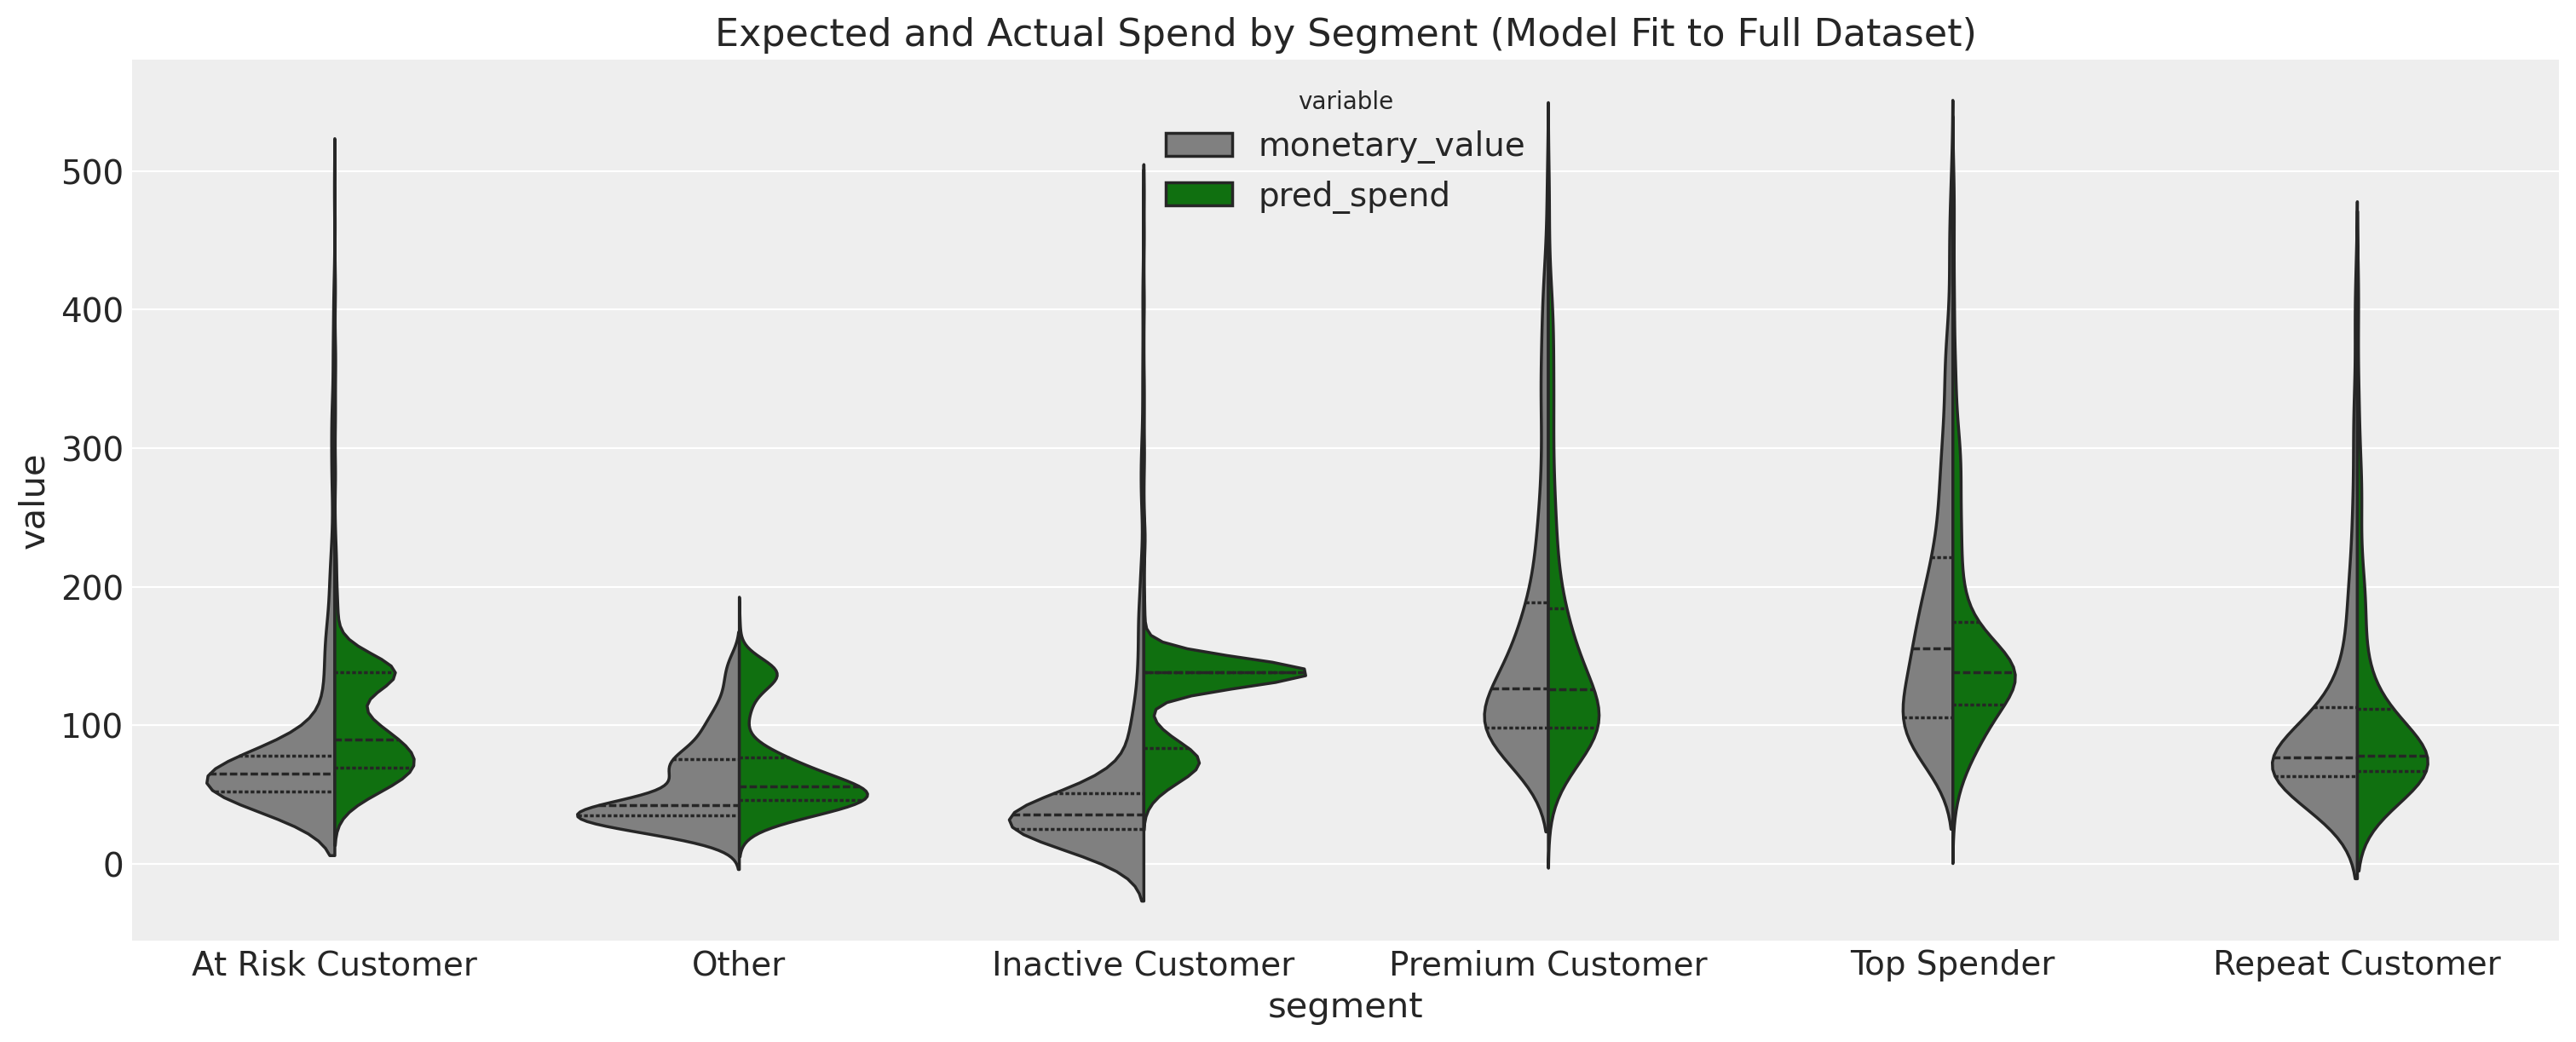

In [234]:
# Create a Matplotlib figure and axes with a specified size (width, height in inches)
fig, ax = plt.subplots(figsize=(15, 6))

trunc_plot_df = full_plot_df[full_plot_df["value"] < 500].copy()

ax.set_title("Expected and Actual Spend by Segment (Model Fit to Full Dataset)")

sb.violinplot(
    data=trunc_plot_df,
    x="segment",
    y="value",
    hue="variable",
    split=True,
    inner="quart",
    fill=True,
    palette={"pred_spend": "g", "monetary_value": ".5"},
    ax=ax,
)
plt.show()

### At-Risk Segment

In [252]:
at_risk

customer_id  frequency  recency     T  monetary_value rfm_score  \
1            1.00       1.00    13.46 15.12           51.73       412   
5           11.00       7.00     5.00  5.67           74.74       422   
9           19.00      10.00    11.56 12.73           71.33       422   
19          37.00       2.00    16.79 19.63           84.39       312   
21          41.00       5.00     1.69 20.04           65.13       122   
...           ...        ...      ...   ...             ...       ...   
2966     4,008.00       1.00     0.50  0.83           50.38       412   
2968     4,010.00       2.00     2.04  3.98           27.91       412   
2976     4,019.00       2.00     2.85  3.77           46.59       412   
2978     4,021.00       4.00     2.96  3.63           79.58       422   
2980     4,023.00       4.00     2.23  2.67           53.75       422   

               segment  original_monetary_value  
1     At Risk Customer                 2,676.46  
5     At Risk Customer                 5,586.73  
9     At Risk Customer                 5,088.14  
19    At Risk Customer                 7,121.16  
21    At Risk Customer                 4,242.47  
...                ...                      ...  
2966  At Risk Customer                 2,538.00  
2968  At Risk Customer                   778.76  
2976  At Risk Customer                 2,170.94  
2978  At Risk Customer                 6,332.53  
2980  At Risk Customer                 2,889.49  

[456 rows x 8 columns]

In [253]:
at_risk_model = clv.GammaGammaModel(data=at_risk)  # , model_config=config)
at_risk_model.build_model()
at_risk_model.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> fit_data

In [254]:
# predictions ran on modeling DF, but appended to segment df (recall modeling df does not include first transactions)
at_risk_seg = rfm_segs[rfm_segs["segment"] == "At Risk Customer"].copy()
# run predictions on all customers (including non-repeats)
at_risk_pred = rfm_df_joined[rfm_df_joined["segment"] == "At Risk Customer"].copy()
# append to seg dataframe containing first transaction values
at_risk_seg["pred_spend"] = (
    at_risk_model.expected_customer_spend(at_risk_pred).mean(("chain", "draw")).values
)  # **2
# rfm_df_transformed["monetary_value"] = np.exp(rfm_df_transformed["monetary_value"])
at_risk_full_plot_df = pd.melt(
    at_risk_seg,
    id_vars=["customer_id", "segment"],
    value_vars=["monetary_value", "pred_spend"],
)
at_risk_seg.describe()

customer_id  frequency  recency  monetary_value  \
count       621.00     621.00   621.00          621.00   
mean      2,423.24       4.25     8.39          135.12   
std       1,110.22       4.14     4.53          225.52   
min           0.00       1.00     0.06           42.87   
25%       1,489.00       1.00     4.75           53.16   
50%       2,622.00       3.00     9.31           66.35   
75%       3,425.00       6.00    11.96           87.76   
max       4,062.00      66.00    19.92        1,921.46   

       original_monetary_value  pred_spend  
count                   621.00      621.00  
mean                 69,035.00       86.37  
std                 298,096.48       83.06  
min                   1,837.99       31.83  
25%                   2,825.94       60.19  
50%                   4,401.92       76.23  
75%                   7,701.55       81.25  
max               3,692,000.01    1,049.57

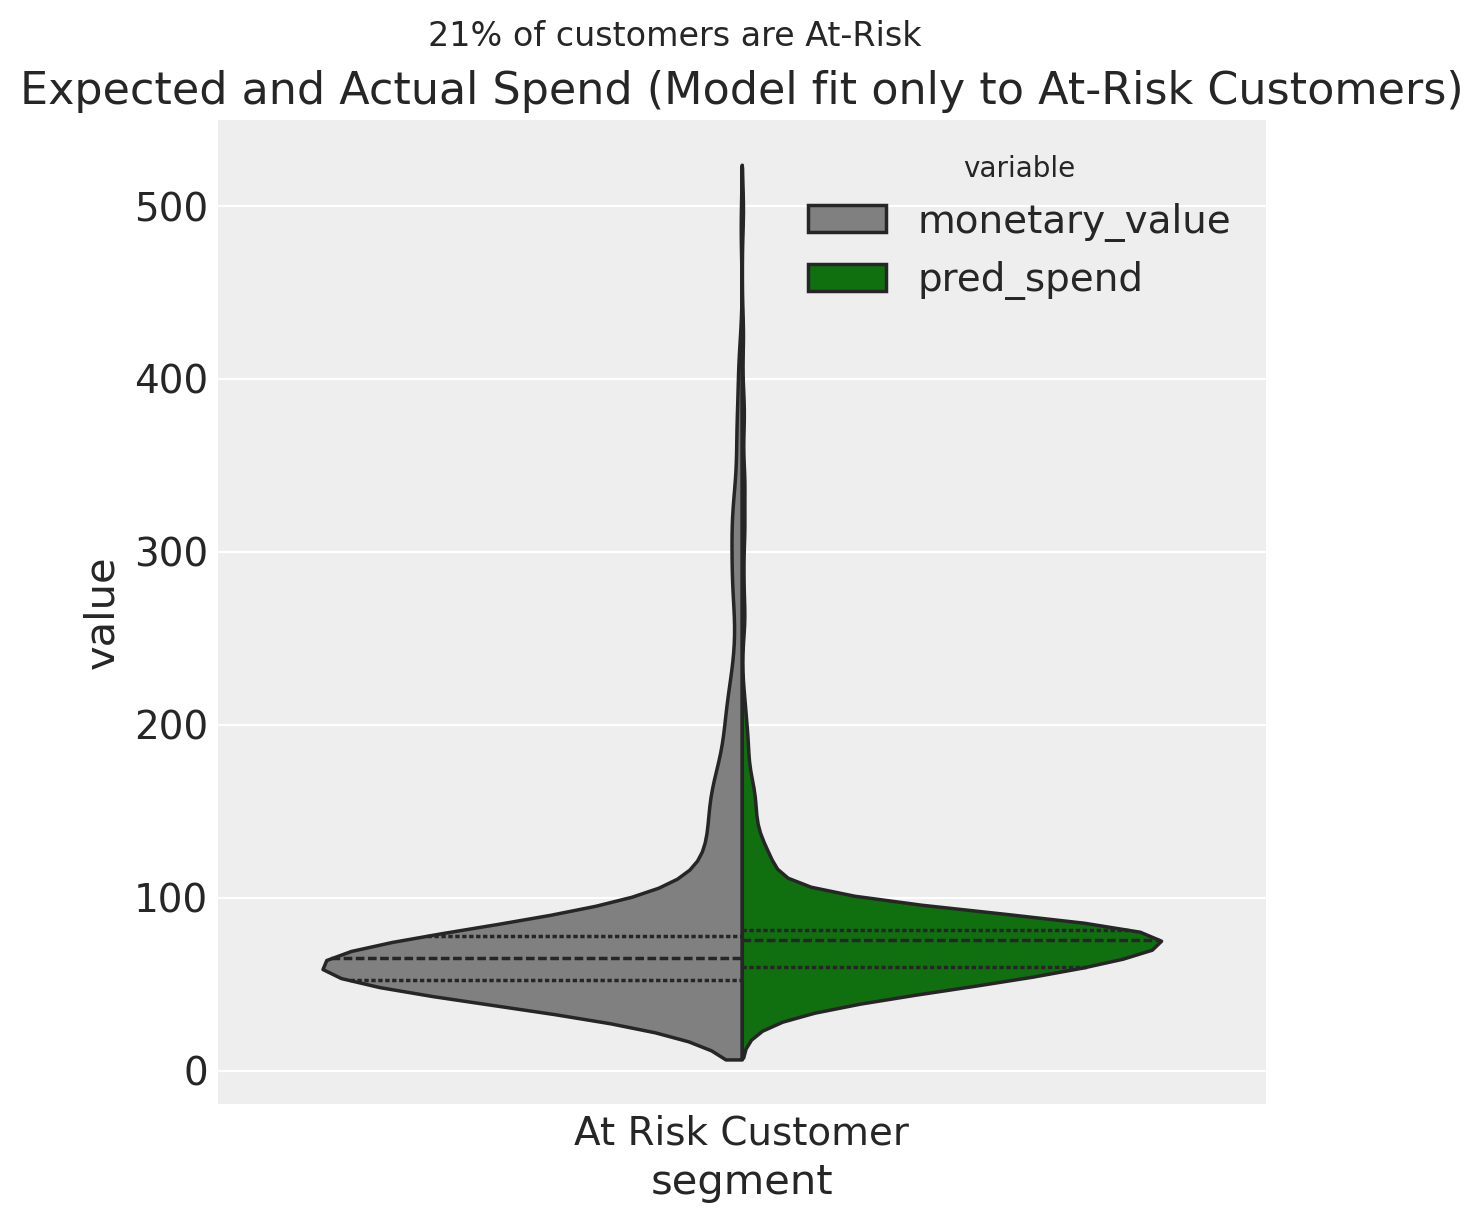

In [266]:
# Create a Matplotlib figure and axes with a specified size (width, height in inches)
fig, ax = plt.subplots(figsize=(6, 6))

trunc_plot_df = at_risk_full_plot_df[at_risk_full_plot_df["value"] < 500].copy()
ax.set_title("Expected and Actual Spend (Model fit only to At-Risk Customers)")

sb.violinplot(
    data=trunc_plot_df,
    x="segment",
    y="value",
    hue="variable",
    split=True,
    inner="quart",
    fill=True,
    cut=2,
    palette={"pred_spend": "g", "monetary_value": ".5"},
    ax=ax,
)
plt.suptitle("21% of customers are At-Risk")
plt.show()

### Inactive Segment

In [235]:
inactive

customer_id  frequency  recency     T  monetary_value rfm_score  \
22          43.00       1.00     0.19 13.48          159.52       113   
57         101.00       2.00     0.25 13.33           18.74       211   
59         105.00       1.00     0.02 16.35           33.75       113   
73         132.00       1.00     6.71 18.79           42.43       211   
76         135.00       2.00     1.48 13.50           40.89       211   
...           ...        ...      ...   ...             ...       ...   
2923     3,963.00       2.00     0.88  5.15           30.17       311   
2958     4,000.00       1.00     2.63  4.38           19.25       411   
2961     4,003.00       1.00     0.06  4.27           23.06       311   
2983     4,026.00       1.00     0.29  2.02           15.17       411   
3012     4,057.00       1.00     0.27  0.77           14.35       411   

                segment  original_monetary_value  
22    Inactive Customer                25,447.28  
57    Inactive Customer                   351.03  
59    Inactive Customer                 1,139.10  
73    Inactive Customer                 1,800.00  
76    Inactive Customer                 1,671.80  
...                 ...                      ...  
2923  Inactive Customer                   910.37  
2958  Inactive Customer                   370.56  
2961  Inactive Customer                   531.58  
2983  Inactive Customer                   230.00  
3012  Inactive Customer                   206.00  

[319 rows x 8 columns]

In [236]:
inactive_model = clv.GammaGammaModel(data=inactive)  # , model_config=config)
inactive_model.build_model()

In [237]:
inactive_model.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> fit_data

In [238]:
# predictions ran on modeling DF, but appended to segment df (recall modeling df does not include first transactions)
inactive_seg = rfm_segs[rfm_segs["segment"] == "Inactive Customer"].copy()
inactive_pred = rfm_df_joined[rfm_df_joined["segment"] == "Inactive Customer"].copy()
inactive_seg["pred_spend"] = (
    inactive_model.expected_customer_spend(inactive_pred).mean(("chain", "draw")).values
)  # **2
# rfm_df_transformed["monetary_value"] = np.exp(rfm_df_transformed["monetary_value"])
inactive_full_plot_df = pd.melt(
    inactive_seg,
    id_vars=["customer_id", "segment"],
    value_vars=["monetary_value", "pred_spend"],
)
inactive_seg.describe()

customer_id  frequency  recency  monetary_value  \
count       866.00     866.00   866.00          866.00   
mean      2,379.28       1.49    13.15           69.38   
std         930.94       0.70     4.33          139.68   
min           7.00       1.00     0.00            7.62   
25%       1,691.25       1.00    12.54           25.60   
50%       2,451.50       1.00    14.31           36.06   
75%       3,137.50       2.00    15.93           53.19   
max       4,057.00       3.00    19.42        1,775.68   

       original_monetary_value  pred_spend  
count                   866.00      866.00  
mean                 24,302.75       61.97  
std                 182,745.25       89.51  
min                      58.00        7.80  
25%                     655.59       45.14  
50%                   1,300.00       58.00  
75%                   2,829.44       58.00  
max               3,153,040.20    1,597.04

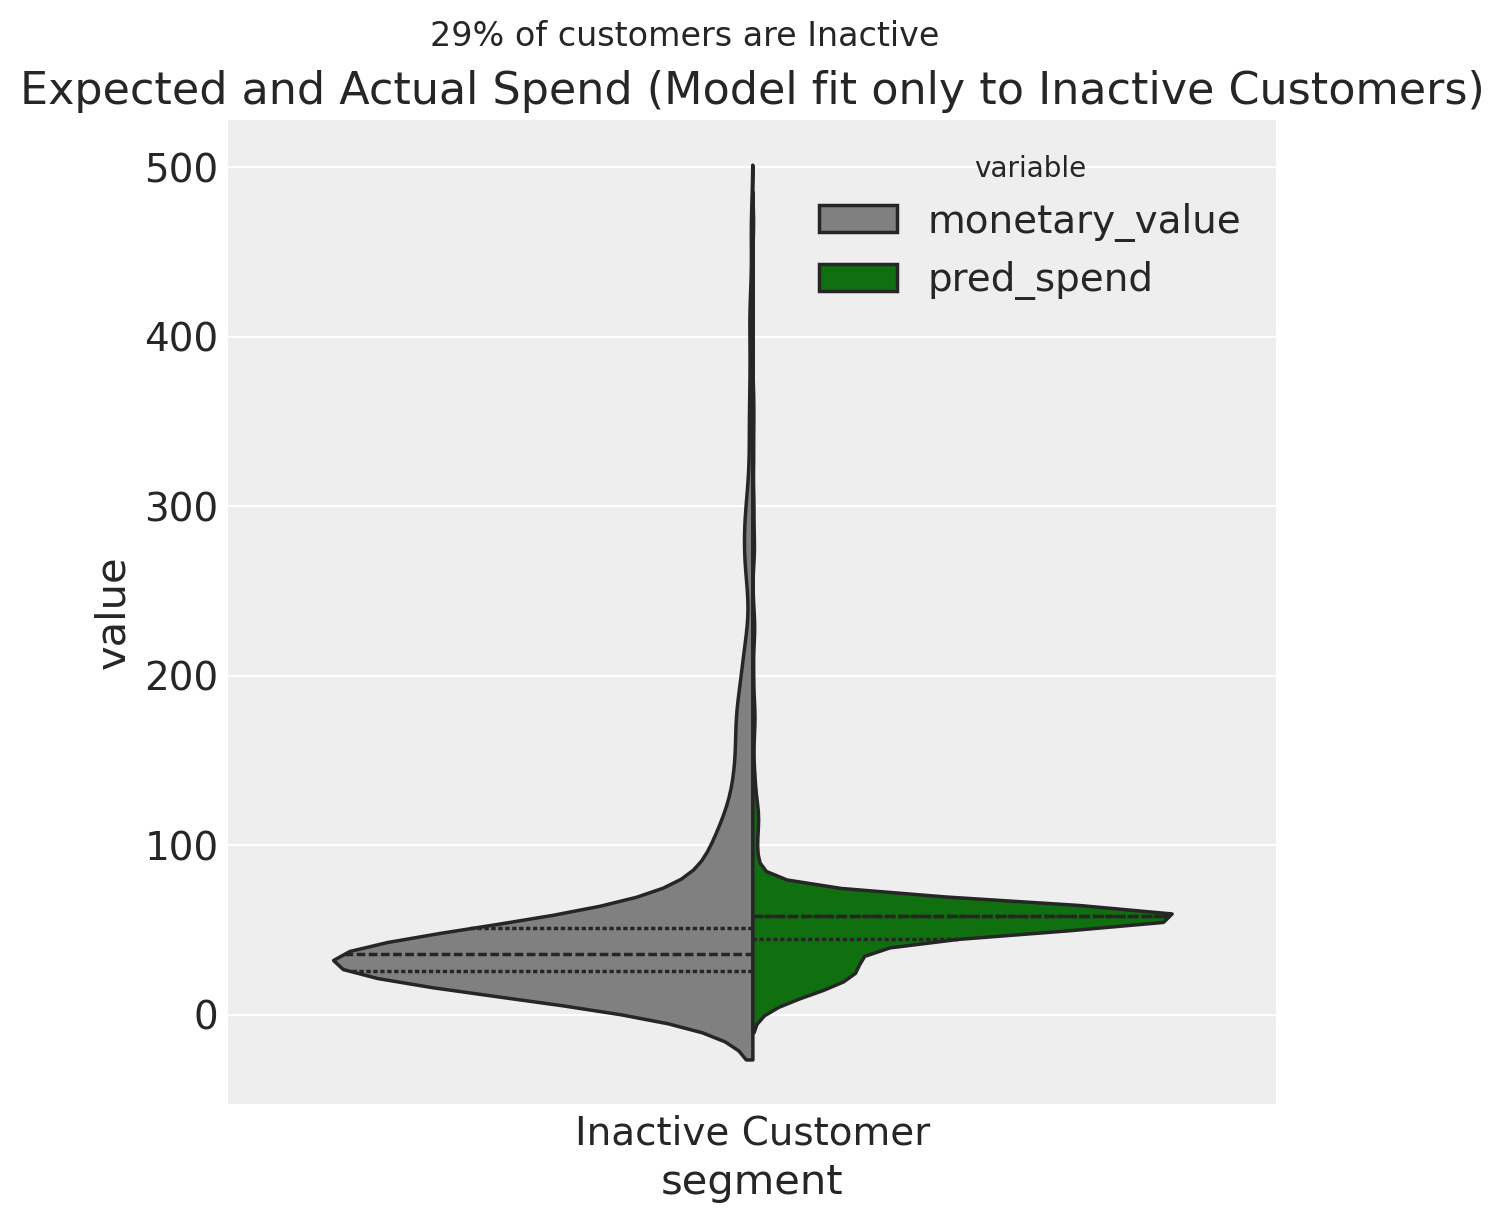

In [267]:
# Create a Matplotlib figure and axes with a specified size (width, height in inches)
fig, ax = plt.subplots(figsize=(6, 6))

trunc_plot_df = inactive_full_plot_df[inactive_full_plot_df["value"] < 500].copy()
ax.set_title("Expected and Actual Spend (Model fit only to Inactive Customers)")

sb.violinplot(
    data=trunc_plot_df,
    x="segment",
    y="value",
    hue="variable",
    split=True,
    inner="quart",
    fill=True,
    cut=2,
    palette={"pred_spend": "g", "monetary_value": ".5"},
    ax=ax,
)
plt.suptitle("29% of customers are Inactive")
plt.show()

# Top Spenders

In [240]:
top

customer_id  frequency  recency     T  monetary_value rfm_score  \
7           16.00       2.00     0.27  2.23          124.36       413   
14          27.00      36.00     6.06 19.62          157.82       134   
16          29.00       9.00     4.44 15.35          329.74       224   
17          30.00       9.00     6.46 17.46          260.84       224   
26          48.00      46.00     5.40 20.06          106.48       133   
...           ...        ...      ...   ...             ...       ...   
3004     4,047.00       1.00     0.17  1.77           81.58       413   
3006     4,049.00       2.00     0.19  0.40           82.14       414   
3015     4,060.00       1.00     0.04  0.15        1,542.34       414   
3018     4,063.00       2.00     0.31  0.83          102.07       413   
3022     4,067.00       1.00     0.35  0.42          133.10       413   

          segment  original_monetary_value  
7     Top Spender                15,465.06  
14    Top Spender                24,908.35  
16    Top Spender               108,726.72  
17    Top Spender                68,036.71  
26    Top Spender                11,338.72  
...           ...                      ...  
3004  Top Spender                 6,655.86  
3006  Top Spender                 6,746.47  
3015  Top Spender             2,378,826.00  
3018  Top Spender                10,418.05  
3022  Top Spender                17,716.41  

[467 rows x 8 columns]

In [246]:
top_spender_model = clv.GammaGammaModel(data=top)  # , model_config=config)
top_spender_model.build_model()
top_spender_model.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> fit_data

In [242]:
idata_mcmc = top_spender_model.fit(**sampler_kwargs)

In [247]:
top_spender_model.fit_summary()

p     2.37
q     2.88
v   186.86
Name: value, dtype: float64

In [248]:
# predictions ran on modeling DF, but appended to segment df (recall modeling df does not include first transactions)
top_seg = rfm_segs[rfm_segs["segment"] == "Top Spender"].copy()
top_pred = rfm_df_joined[rfm_df_joined["segment"] == "Top Spender"].copy()
top_seg["pred_spend"] = (
    top_spender_model.expected_customer_spend(top_pred).mean(("chain", "draw")).values
)  # **2
# rfm_df_transformed["monetary_value"] = np.exp(rfm_df_transformed["monetary_value"])
top_full_plot_df = pd.melt(
    top_seg,
    id_vars=["customer_id", "segment"],
    value_vars=["monetary_value", "pred_spend"],
)
top_seg.describe()

customer_id  frequency  recency  monetary_value  \
count       614.00     614.00   614.00          614.00   
mean      2,594.28       4.99     4.74          264.37   
std       1,217.75       6.19     3.91          265.95   
min          16.00       1.00     0.00           78.42   
25%       1,605.50       2.00     1.37          113.90   
50%       2,845.50       4.00     4.23          169.80   
75%       3,720.75       7.00     6.86          288.34   
max       4,067.00      95.00    16.31        1,931.36   

       original_monetary_value  pred_spend  
count                   614.00      614.00  
mean                140,501.98      237.88  
std                 377,303.52      173.71  
min                   6,149.53       54.67  
25%                  12,972.45      141.16  
50%                  28,831.18      207.51  
75%                  83,142.67      235.93  
max               3,730,155.00    1,539.12

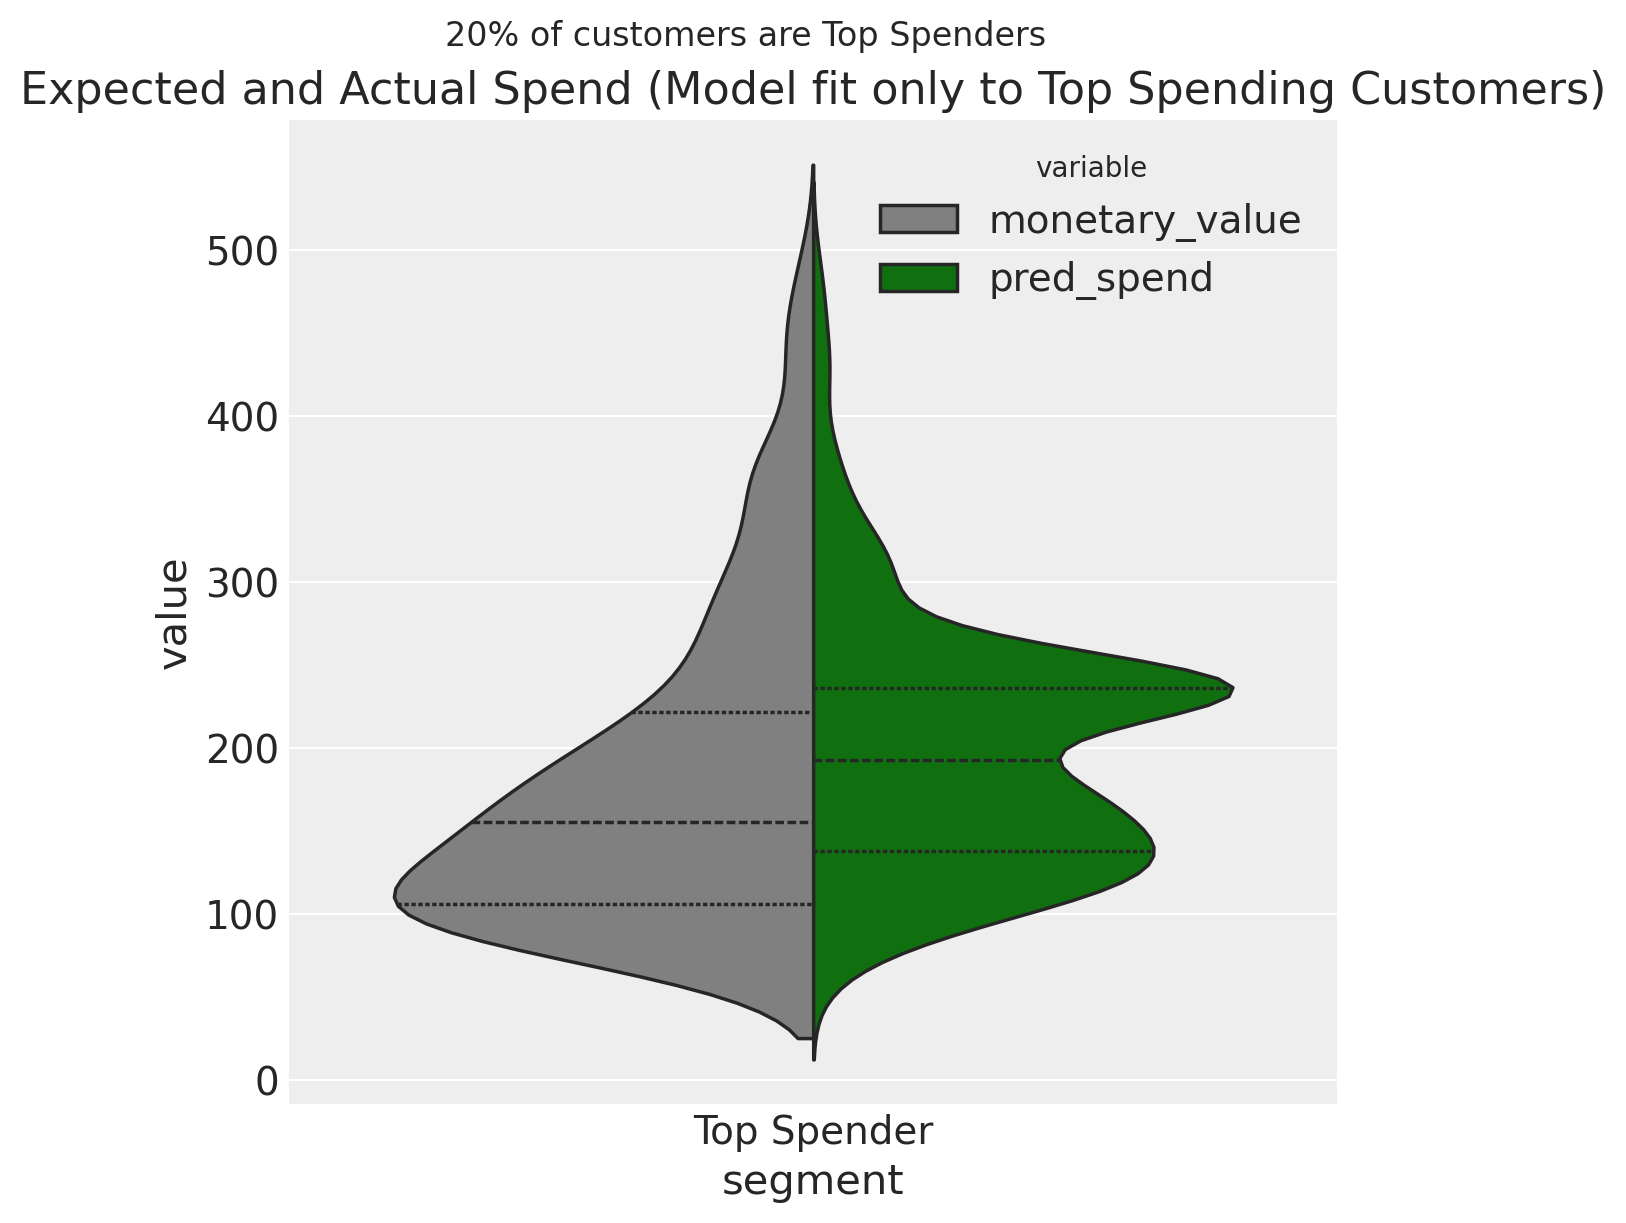

In [268]:
# Create a Matplotlib figure and axes with a specified size (width, height in inches)
fig, ax = plt.subplots(figsize=(6, 6))

trunc_plot_df = top_full_plot_df[top_full_plot_df["value"] < 500].copy()
ax.set_title("Expected and Actual Spend (Model fit only to Top Spending Customers)")

sb.violinplot(
    data=trunc_plot_df,
    x="segment",
    y="value",
    hue="variable",
    split=True,
    inner="quart",
    fill=True,
    cut=2,
    palette={"pred_spend": "g", "monetary_value": ".5"},
    ax=ax,
)
plt.suptitle("20% of customers are Top Spenders")
plt.show()

# Legacy Per-Segment Code

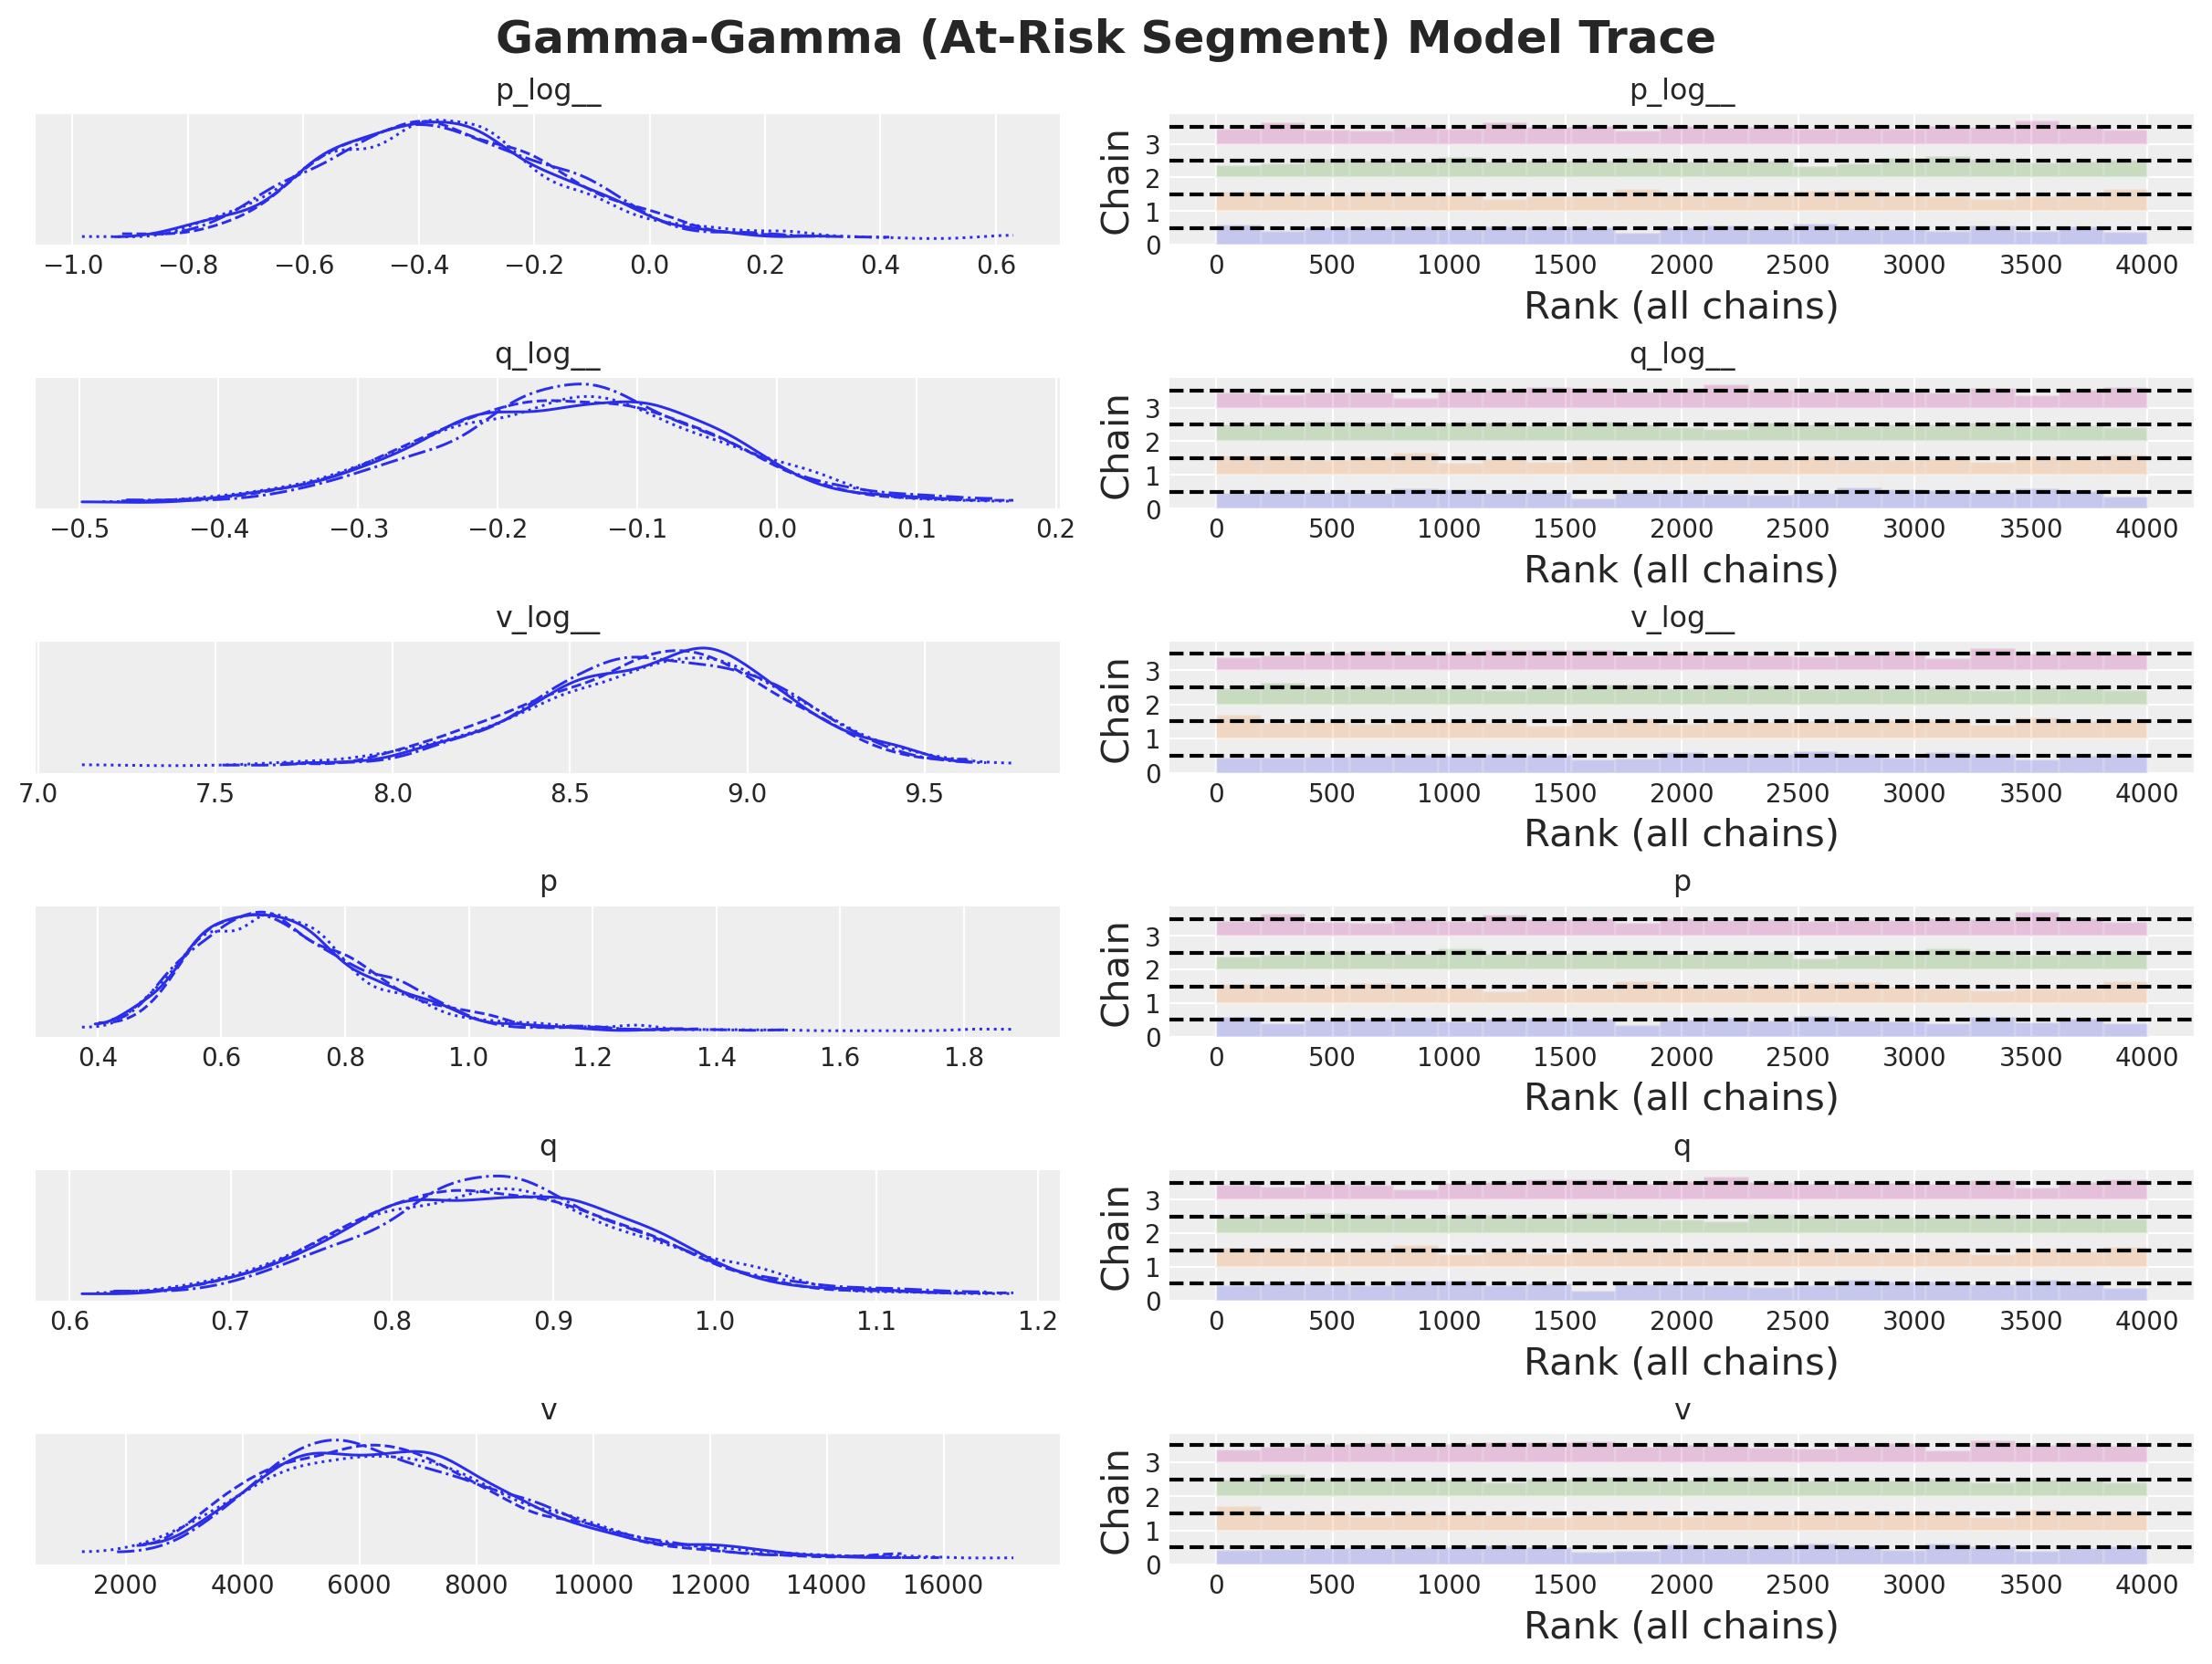

In [30]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (At-Risk Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Inactive Segment

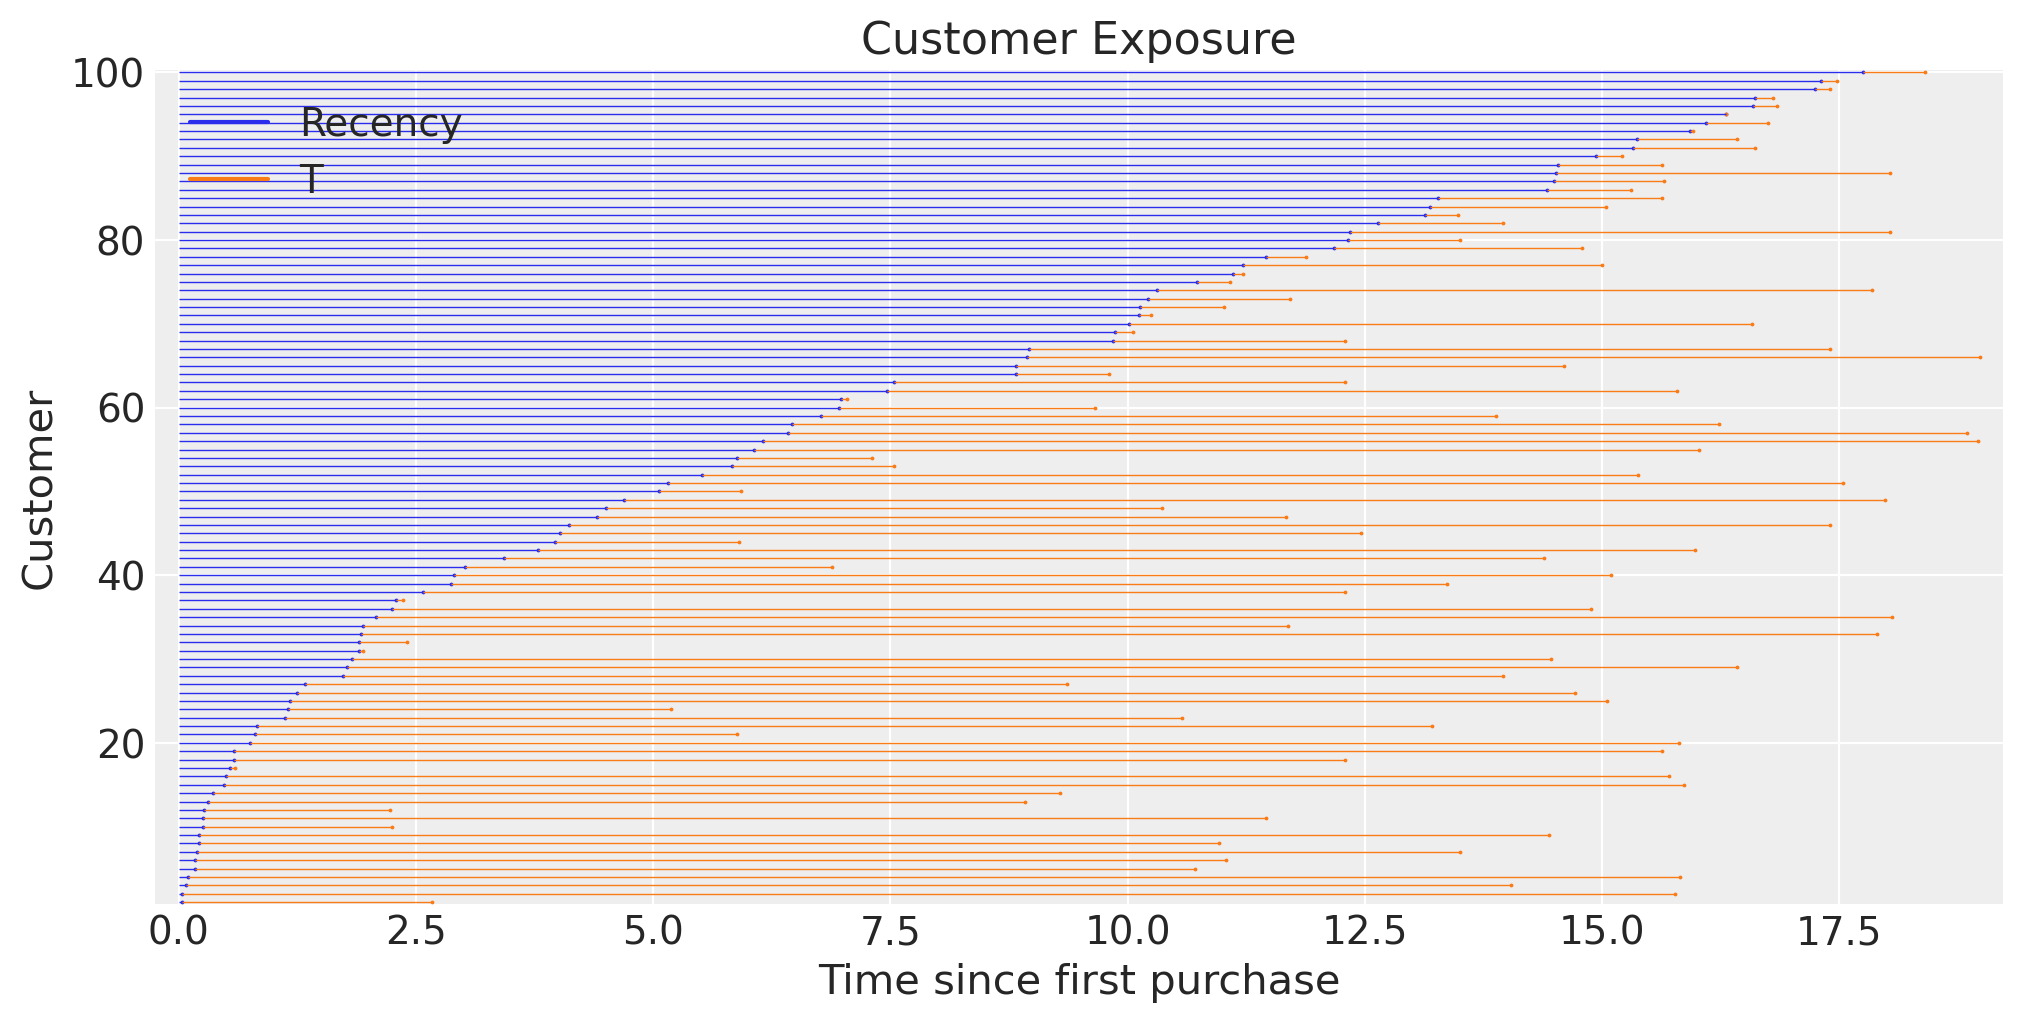

In [31]:
# Customer exposure plot for the inactive segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    inactive.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [32]:
model = clv.GammaGammaModel(data=inactive)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [33]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [34]:
idata_mcmc = model.fit(**sampler_kwargs)

In [35]:
model.fit_summary()

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p_log__    -0.42     0.18    -0.74    -0.08       0.01     0.00  1,116.00   
q_log__    -0.31     0.08    -0.46    -0.15       0.00     0.00  1,668.00   
v_log__     8.66     0.31     8.08     9.26       0.01     0.01  1,035.00   
p           0.67     0.12     0.47     0.91       0.00     0.00  1,116.00   
q           0.74     0.06     0.63     0.85       0.00     0.00  1,668.00   
v       6,079.45 1,923.35 2,798.63 9,662.69      59.06    52.52  1,035.00   

         ess_tail  r_hat  
p_log__  1,065.00   1.00  
q_log__  1,820.00   1.00  
v_log__    915.00   1.00  
p        1,065.00   1.00  
q        1,820.00   1.00  
v          915.00   1.00

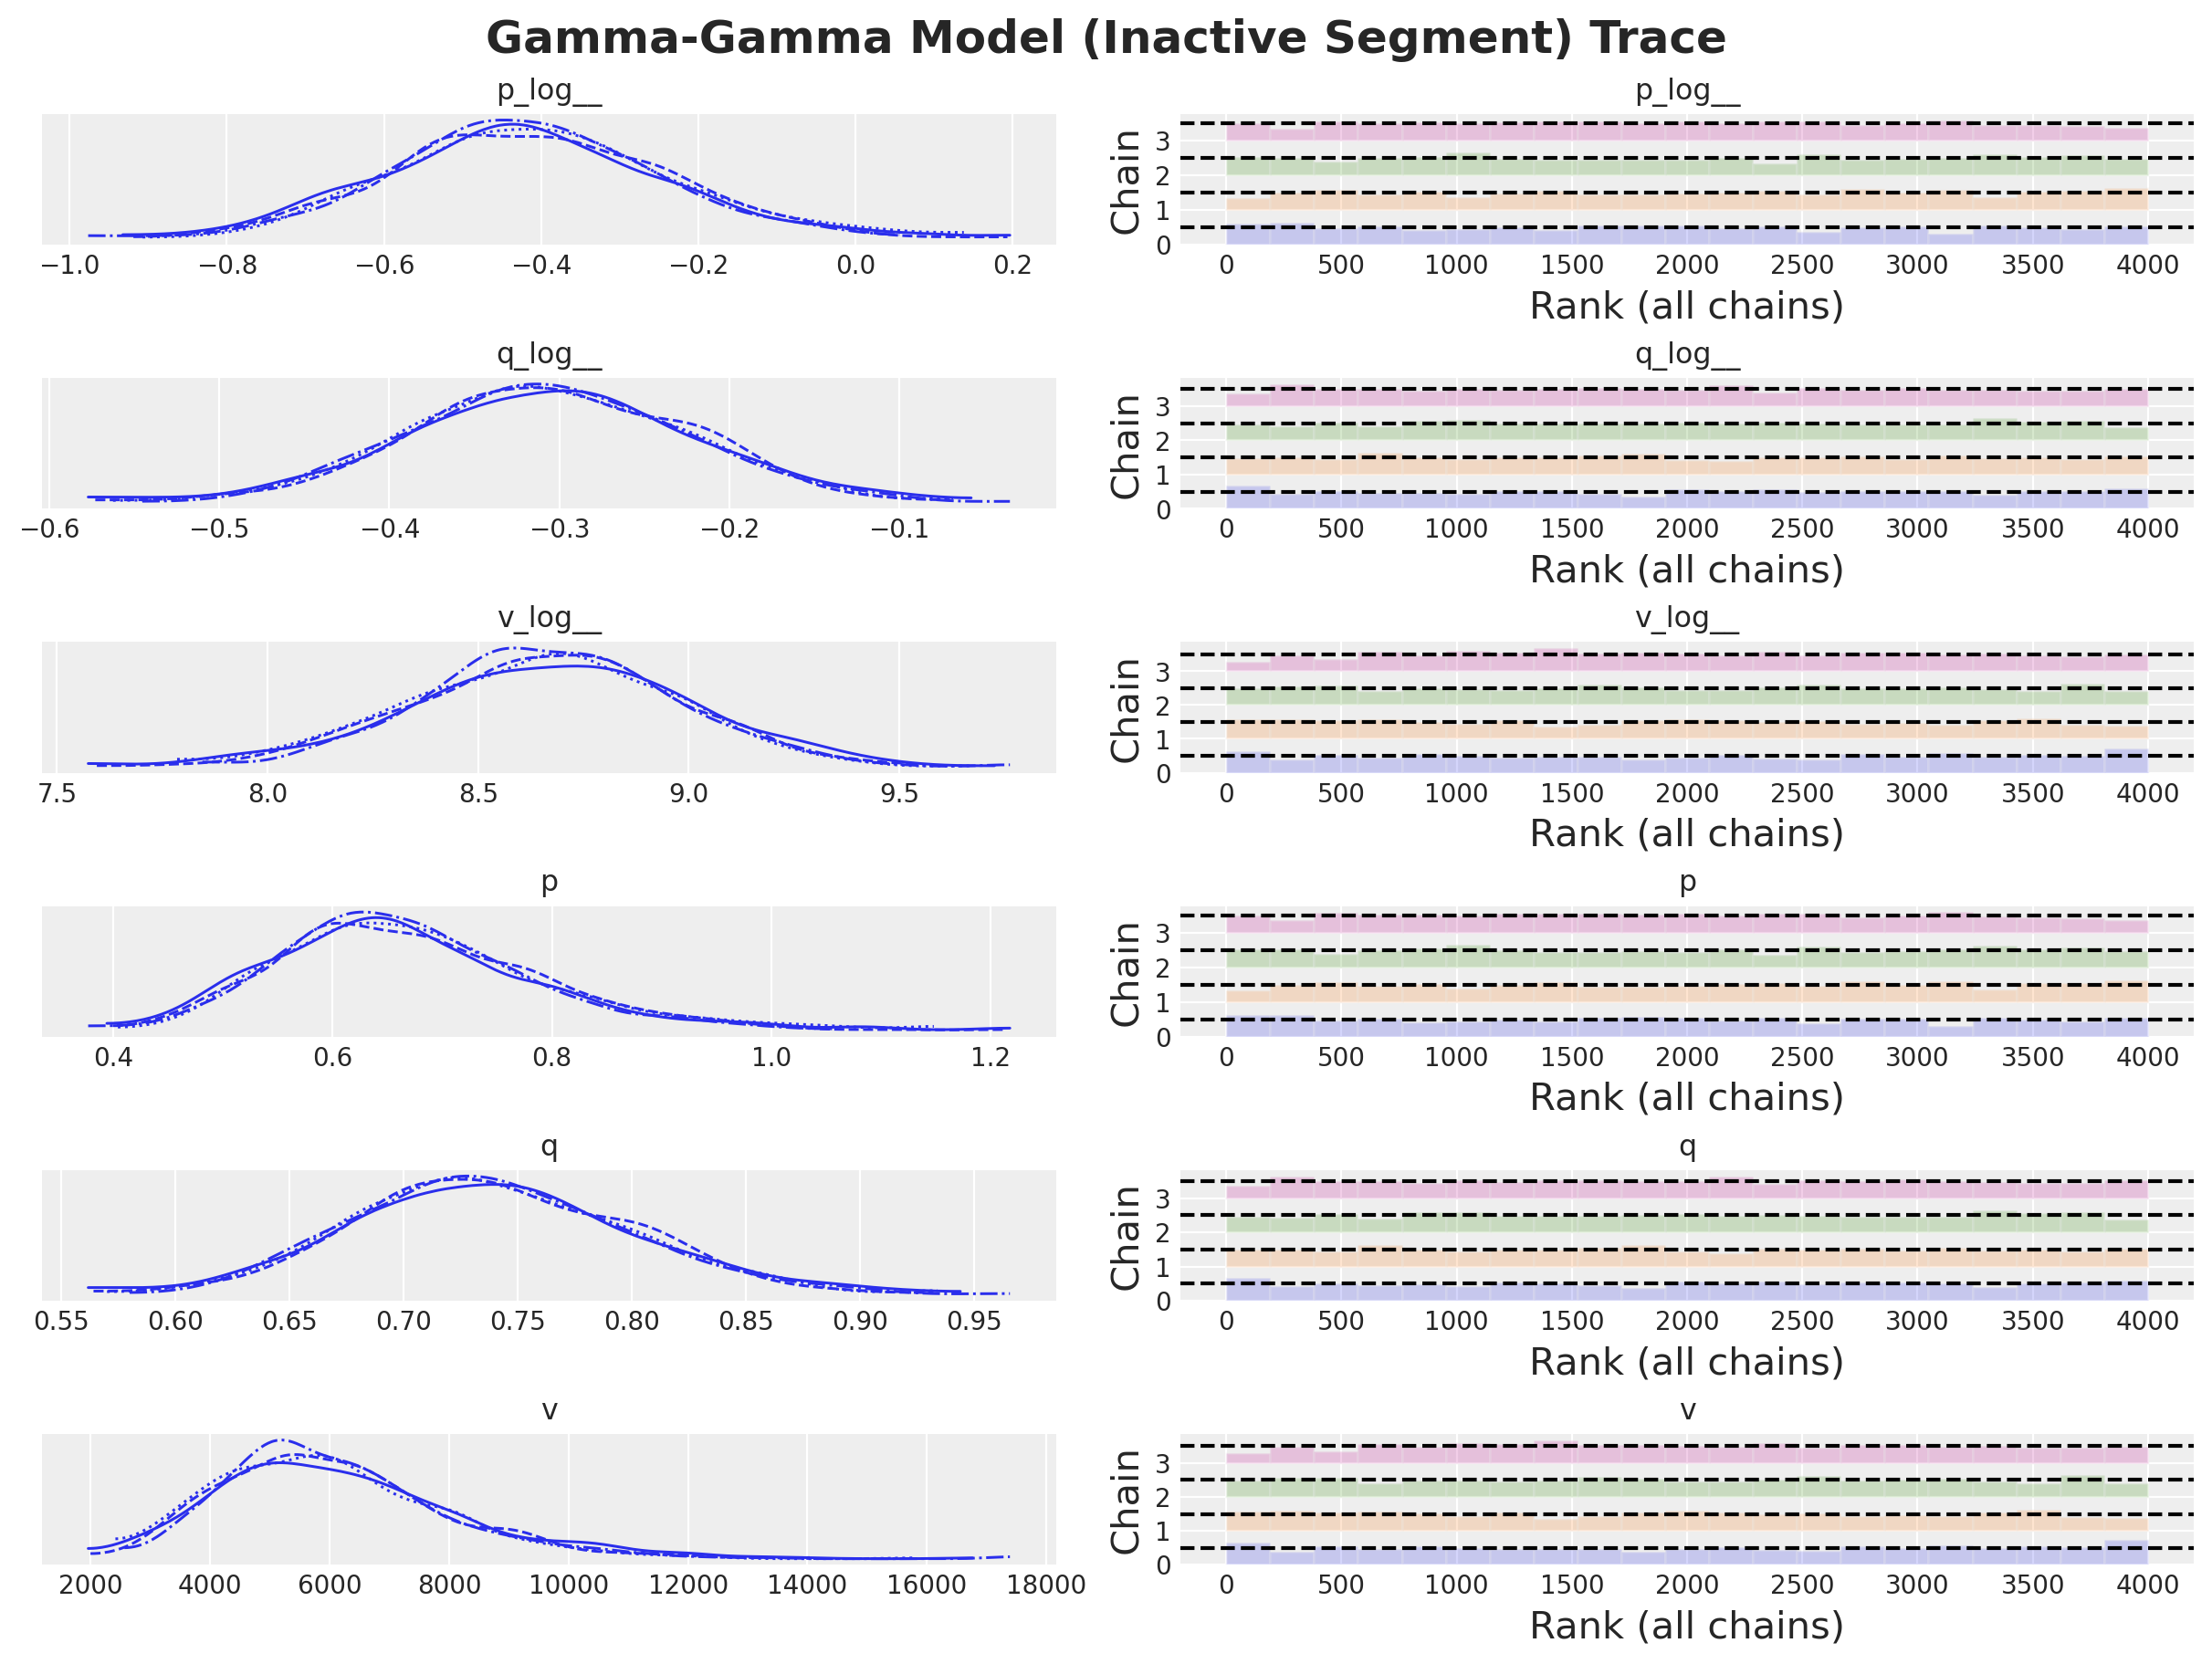

In [36]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma Model (Inactive Segment) Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Low Spender Segment

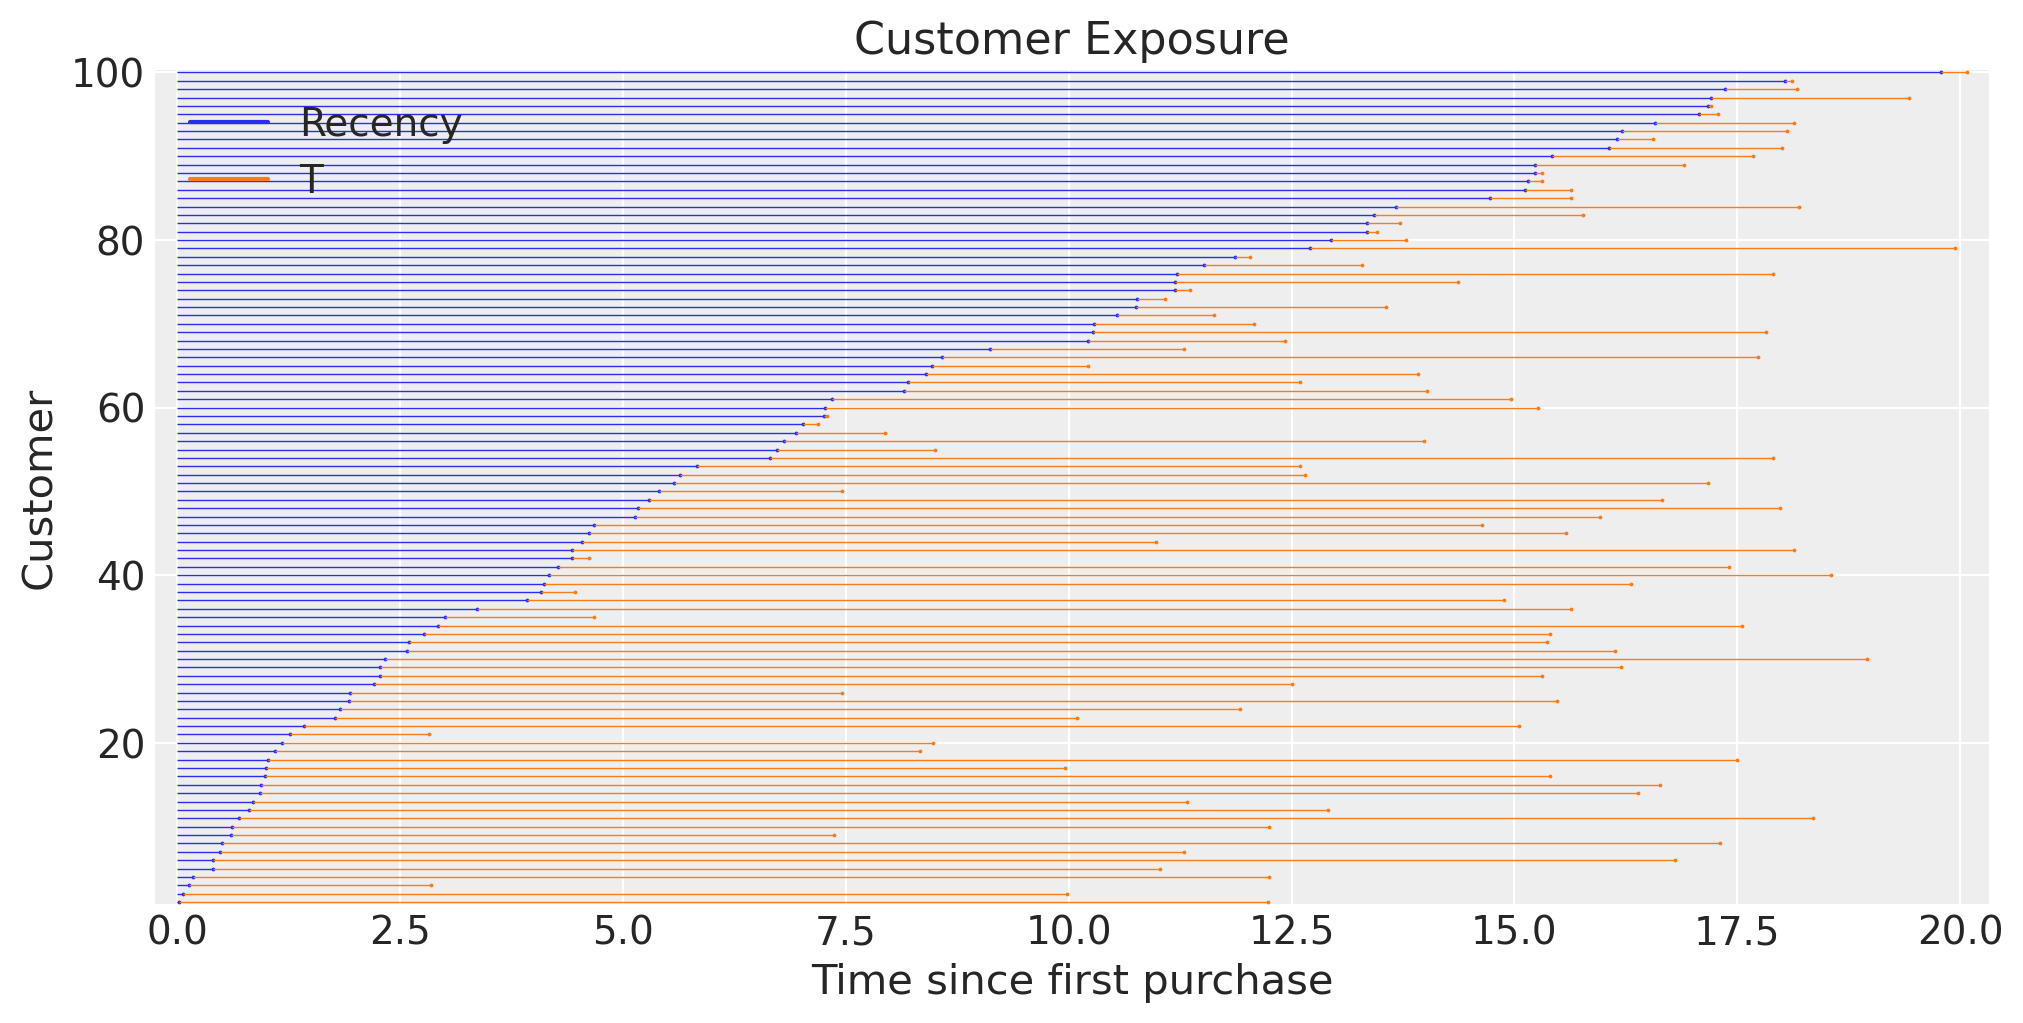

In [37]:
# Customer exposure plot for the low_spender segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    low_spender.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [38]:
model = clv.GammaGammaModel(data=low_spender)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [39]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [40]:
idata_mcmc = model.fit(**sampler_kwargs)

In [41]:
model.fit_summary()

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p_log__    -0.60     0.27    -1.09     -0.09       0.01     0.01  1,021.00   
q_log__    -0.30     0.11    -0.53     -0.10       0.00     0.00  1,653.00   
v_log__     8.85     0.46     7.96      9.66       0.01     0.01    980.00   
p           0.57     0.16     0.31      0.87       0.01     0.01  1,021.00   
q           0.74     0.09     0.59      0.90       0.00     0.00  1,653.00   
v       7,755.13 3,691.21 2,263.51 14,458.32     117.88   149.28    980.00   

         ess_tail  r_hat  
p_log__  1,244.00   1.00  
q_log__  1,973.00   1.00  
v_log__  1,180.00   1.00  
p        1,244.00   1.00  
q        1,973.00   1.00  
v        1,180.00   1.00

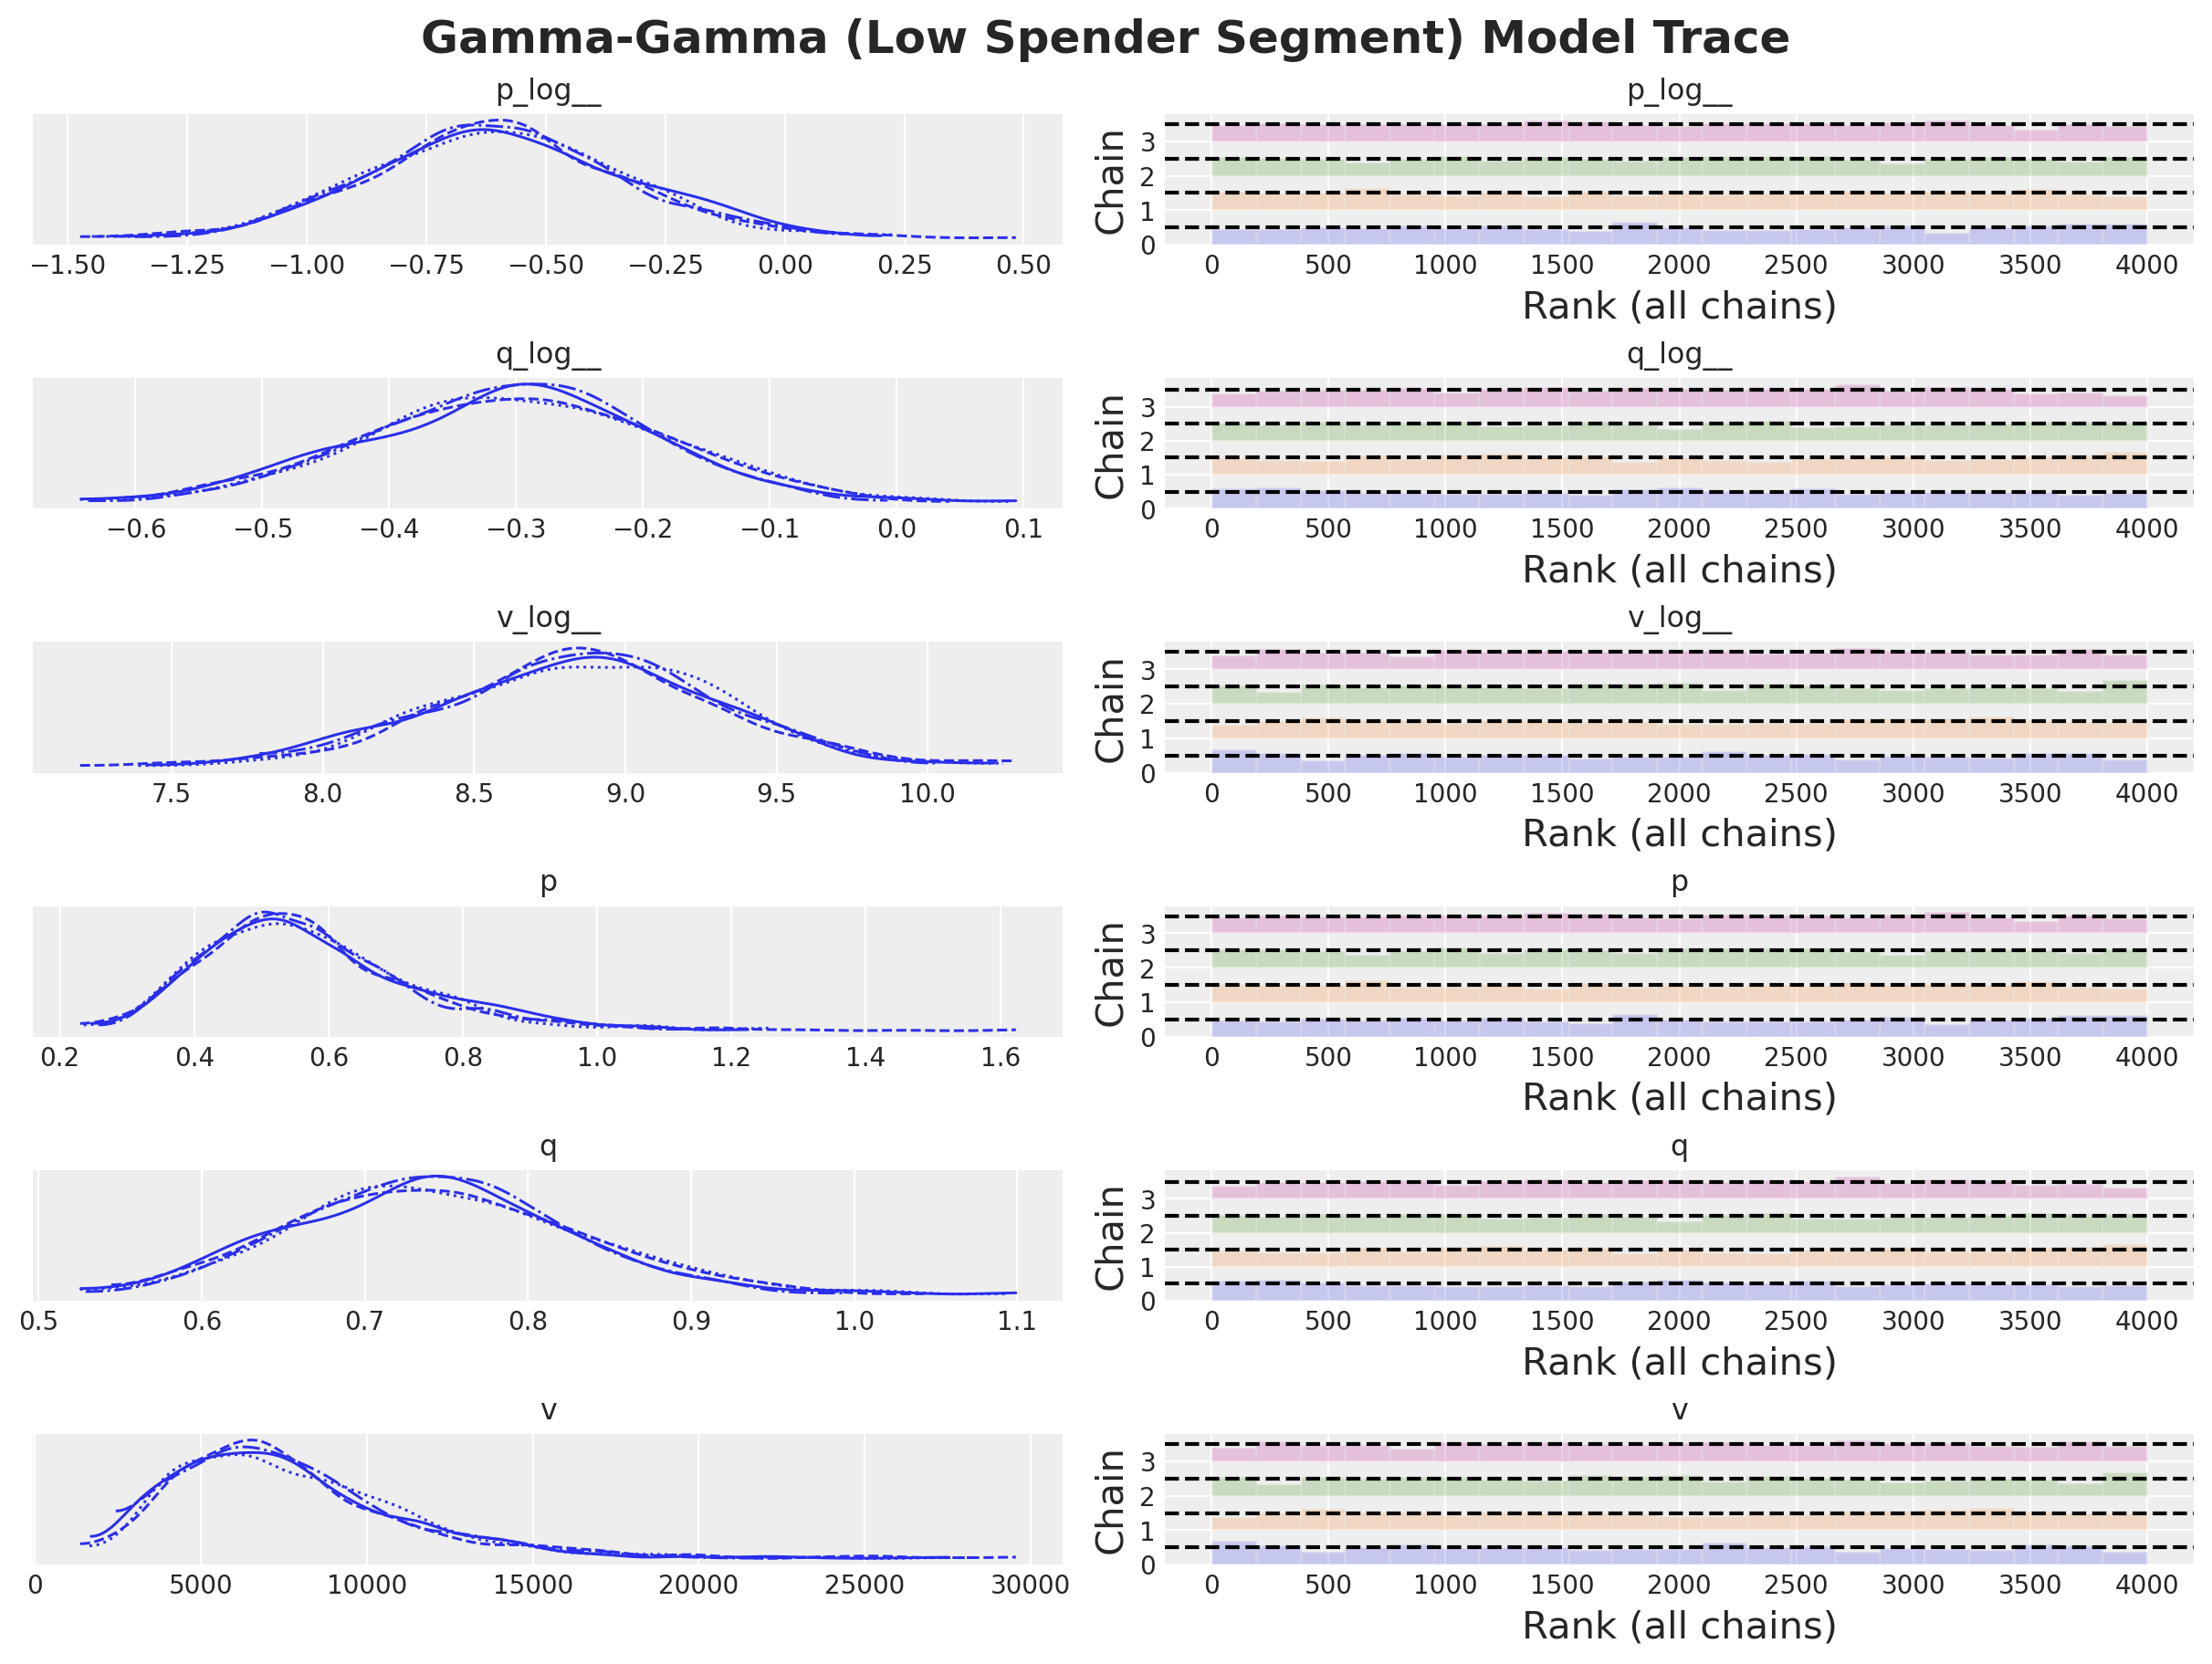

In [42]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (Low Spender Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Premium Segment

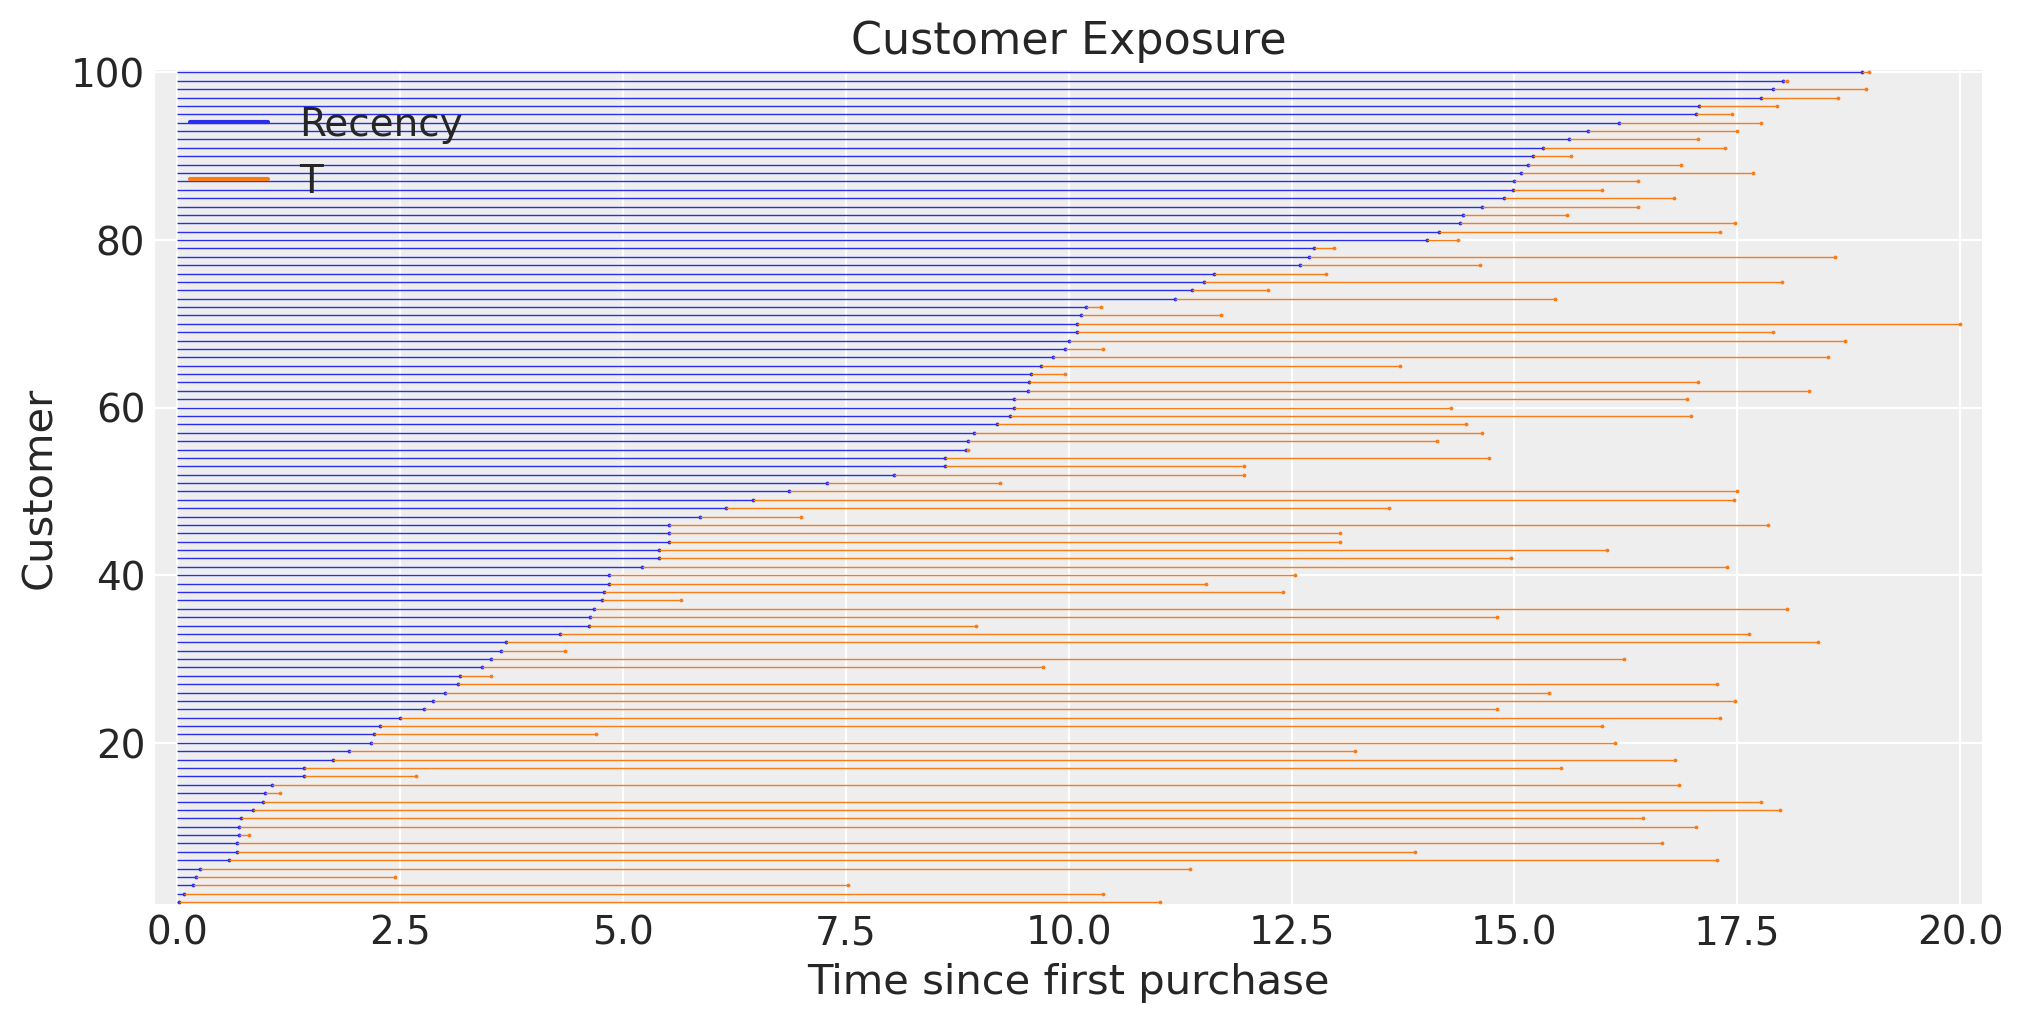

In [43]:
# Customer exposure plot for the premium segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    premium.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [44]:
model = clv.GammaGammaModel(data=premium)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [45]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [46]:
idata_mcmc = model.fit(**sampler_kwargs)

In [47]:
model.fit_summary()

mean                   sd  hdi_3%  \
p_log__                14.07                14.40   -0.62   
q_log__                -0.49                 0.20   -0.71   
v_log__                -6.25                14.82  -21.07   
p       1,153,997,137,034.86 1,154,292,623,571.42    0.54   
q                       0.62                 0.13    0.49   
v                   2,886.43             3,368.59    0.00   

                     hdi_97%          mcse_mean          mcse_sd  ess_bulk  \
p_log__                28.48               7.17             0.01      5.00   
q_log__                -0.19               0.09             0.01      5.00   
v_log__                 9.05               7.38             0.01      5.00   
p       2,334,412,854,023.05 574,833,090,806.53 9,302,027,994.38      5.00   
q                       0.82               0.06             0.01      5.00   
v                   8,549.66           1,443.85            81.42      5.00   

         ess_tail  r_hat  
p_log__    292.00   2.34  
q_log__     13.00   2.16  
v_log__     13.00   2.30  
p          292.00   2.34  
q           13.00   2.16  
v           13.00   2.30

/Users/coltallen/mamba/envs/pymc-marketing-dev/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/coltallen/mamba/envs/pymc-marketing-dev/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


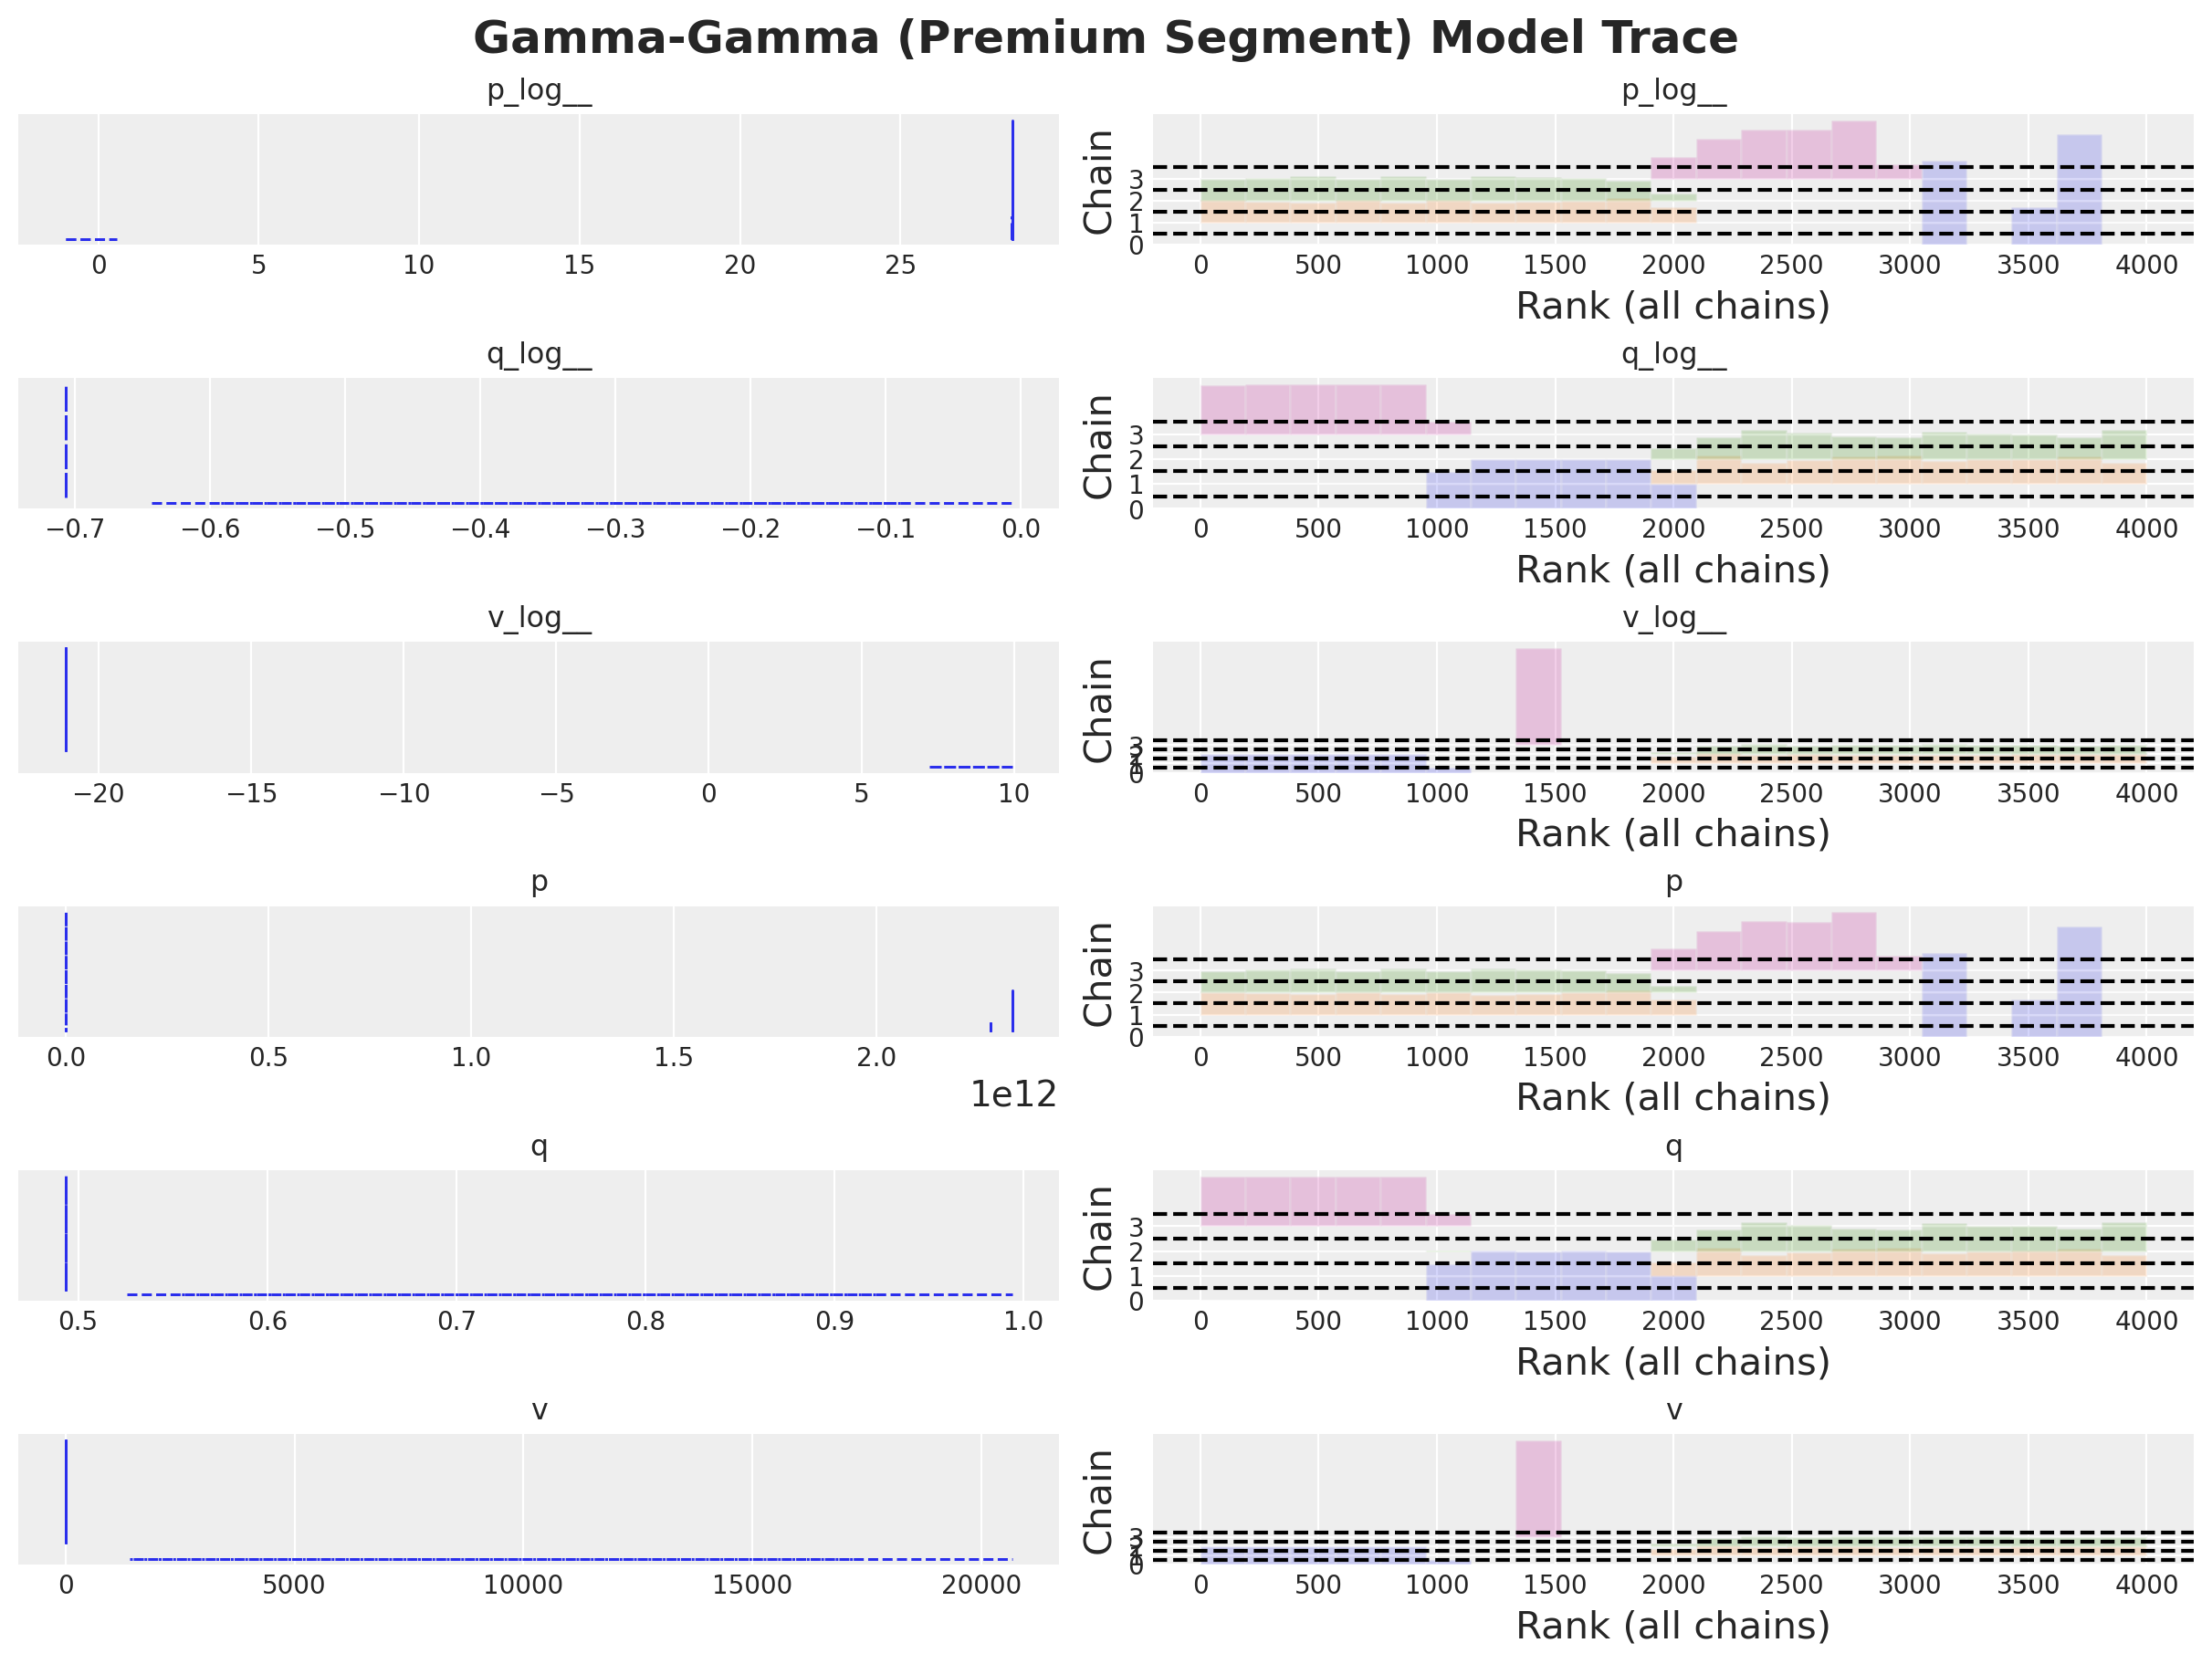

In [48]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (Premium Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Repeat Segment

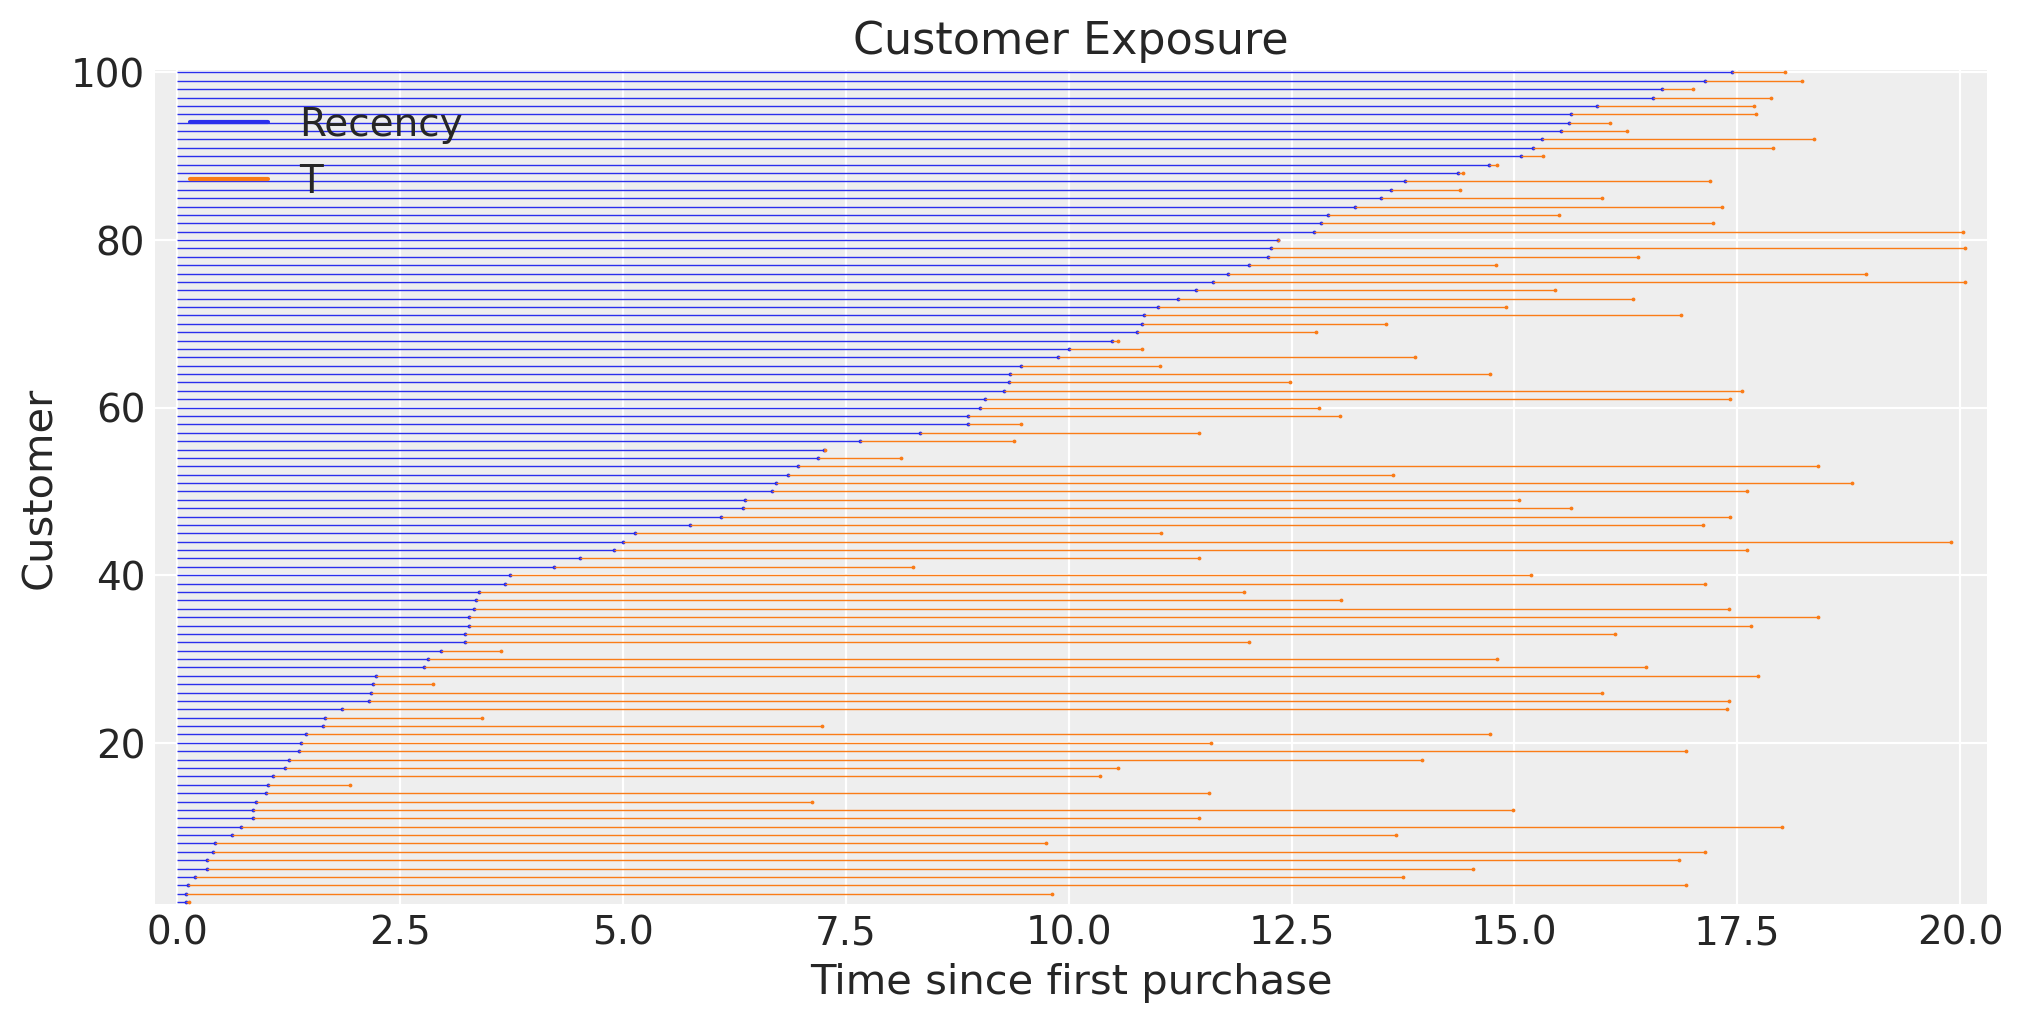

In [49]:
# Customer exposure plot for the repeat segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    repeat.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [50]:
model = clv.GammaGammaModel(data=repeat)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [51]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [52]:
idata_mcmc = model.fit(**sampler_kwargs)

In [53]:
model.fit_summary()

mean                   sd  hdi_3%              hdi_97%  \
p_log__               6.83                12.60   -0.91                28.64   
q_log__              -0.38                 0.22   -0.70                -0.08   
v_log__               1.21                13.17  -21.59                 9.57   
p       688,253,198,845.30 1,192,238,548,004.71    0.34 2,753,012,795,389.20   
q                     0.70                 0.15    0.50                 0.92   
v                 5,795.57             5,011.25    0.00            14,279.90   

                 mcse_mean            mcse_sd  ess_bulk  ess_tail  r_hat  
p_log__               6.27               3.62      7.00     39.00   1.53  
q_log__               0.09               0.04      7.00     12.00   1.58  
v_log__               6.56               3.78      7.00     19.00   1.54  
p       593,730,008,780.42 342,747,328,944.40      7.00     39.00   1.53  
q                     0.06               0.02      7.00     12.00   1.58  
v                 1,692.96             145.82      7.00     19.00   1.54

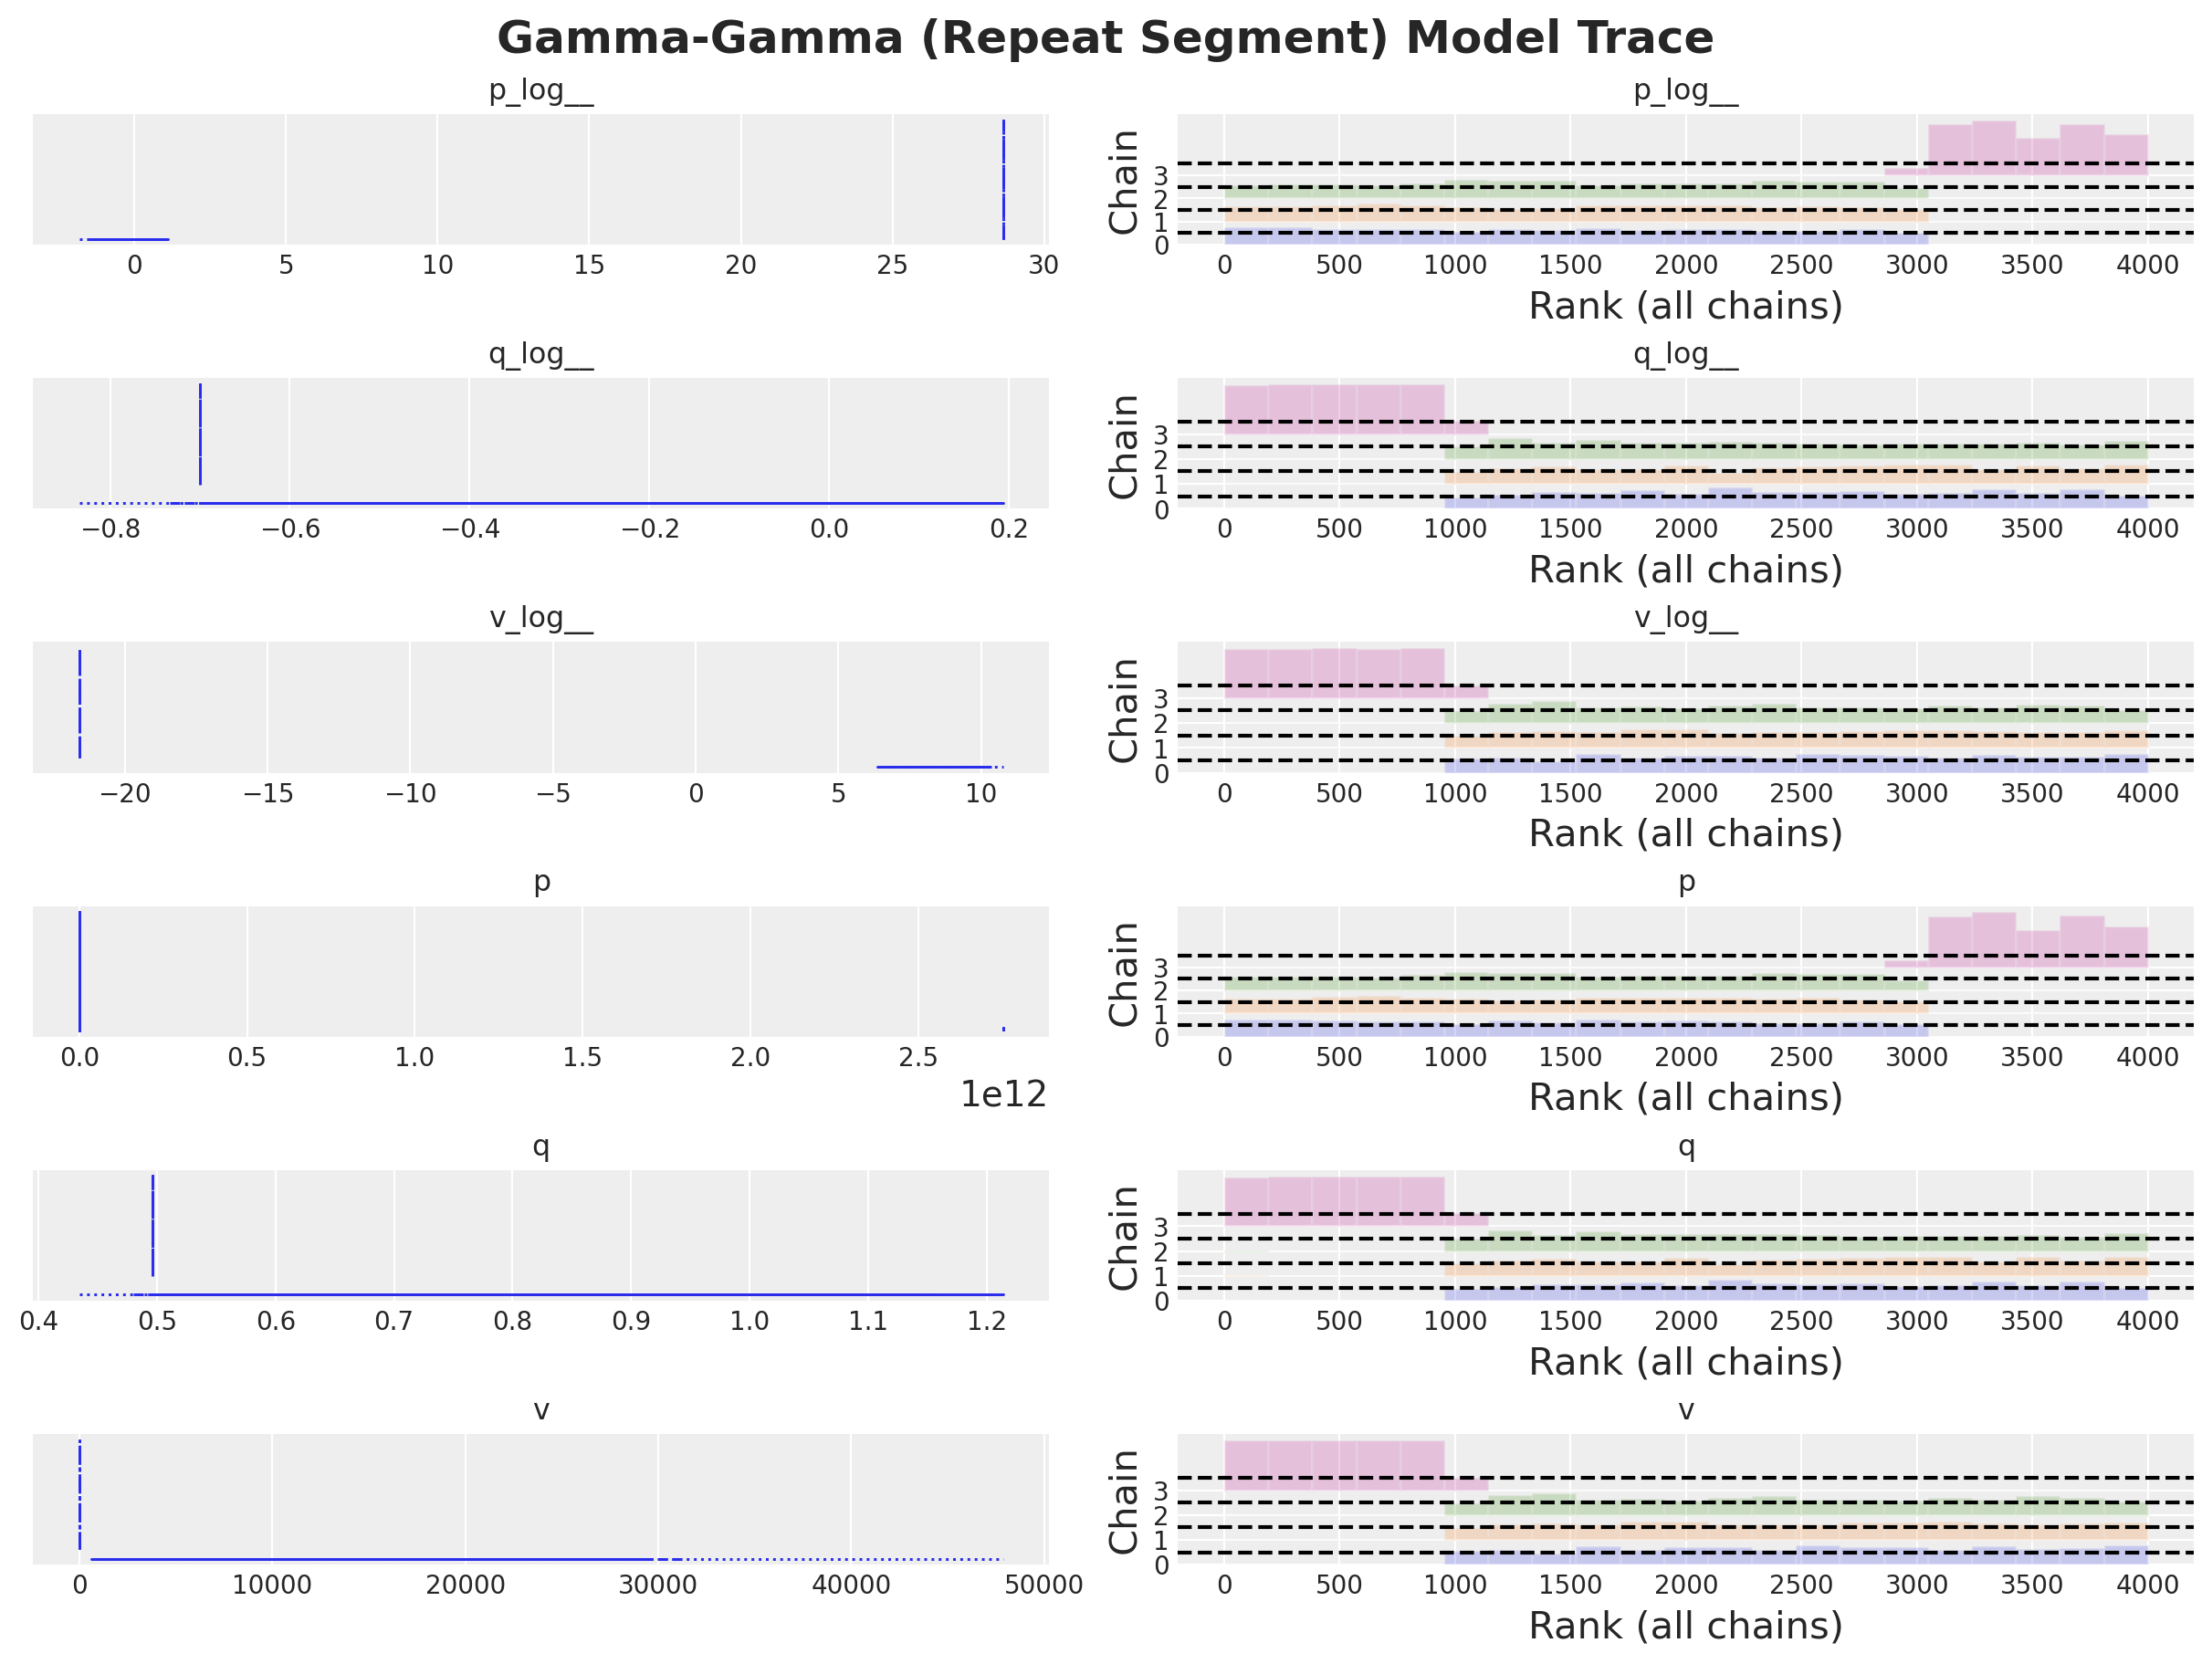

In [54]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (Repeat Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

### Top Spender Segment

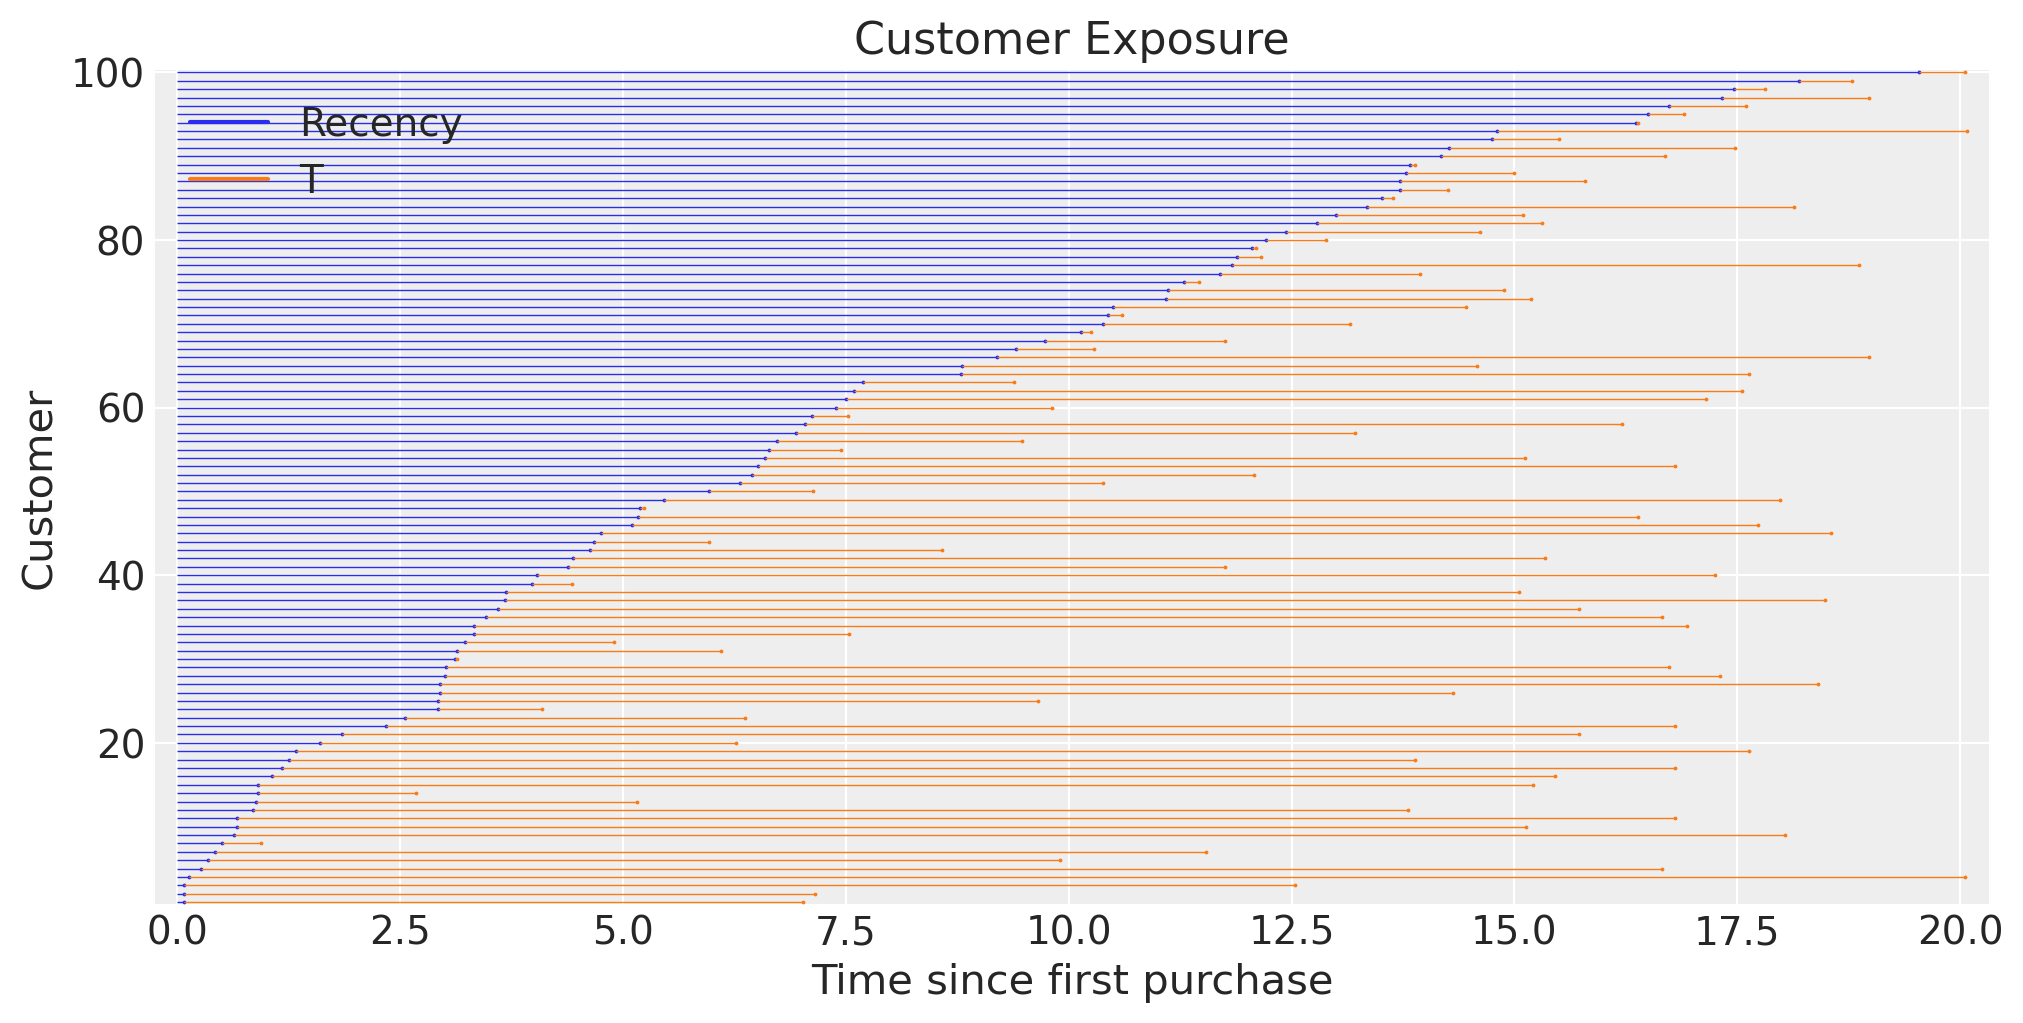

In [55]:
# Customer exposure plot for the top segment

fig, ax = plt.subplots(figsize=(10, 5))
(
    top.sample(n=100, random_state=random_seed)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

In [56]:
model = clv.GammaGammaModel(data=top)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [57]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [58]:
idata_mcmc = model.fit(**sampler_kwargs)

In [59]:
model.fit_summary()

mean                 sd  hdi_3%            hdi_97%  \
p_log__              6.12              11.88   -0.97              26.69   
q_log__             -0.14               0.32   -0.67               0.18   
v_log__              2.35              12.73  -19.69              10.12   
p       97,608,170,411.20 169,083,447,137.22    0.30 390,432,681,648.49   
q                    0.91               0.25    0.52               1.20   
v               12,706.82           8,628.26    0.00          24,924.72   

                mcse_mean           mcse_sd  ess_bulk  ess_tail  r_hat  
p_log__              5.92              3.41      7.00     19.00   1.57  
q_log__              0.15              0.08      7.00     11.00   1.59  
v_log__              6.34              3.66      7.00     14.00   1.54  
p       84,202,877,621.61 48,608,476,862.27      7.00     19.00   1.57  
q                    0.11              0.05      7.00     11.00   1.59  
v                3,693.04          1,468.47      7.00     14.00   1.54

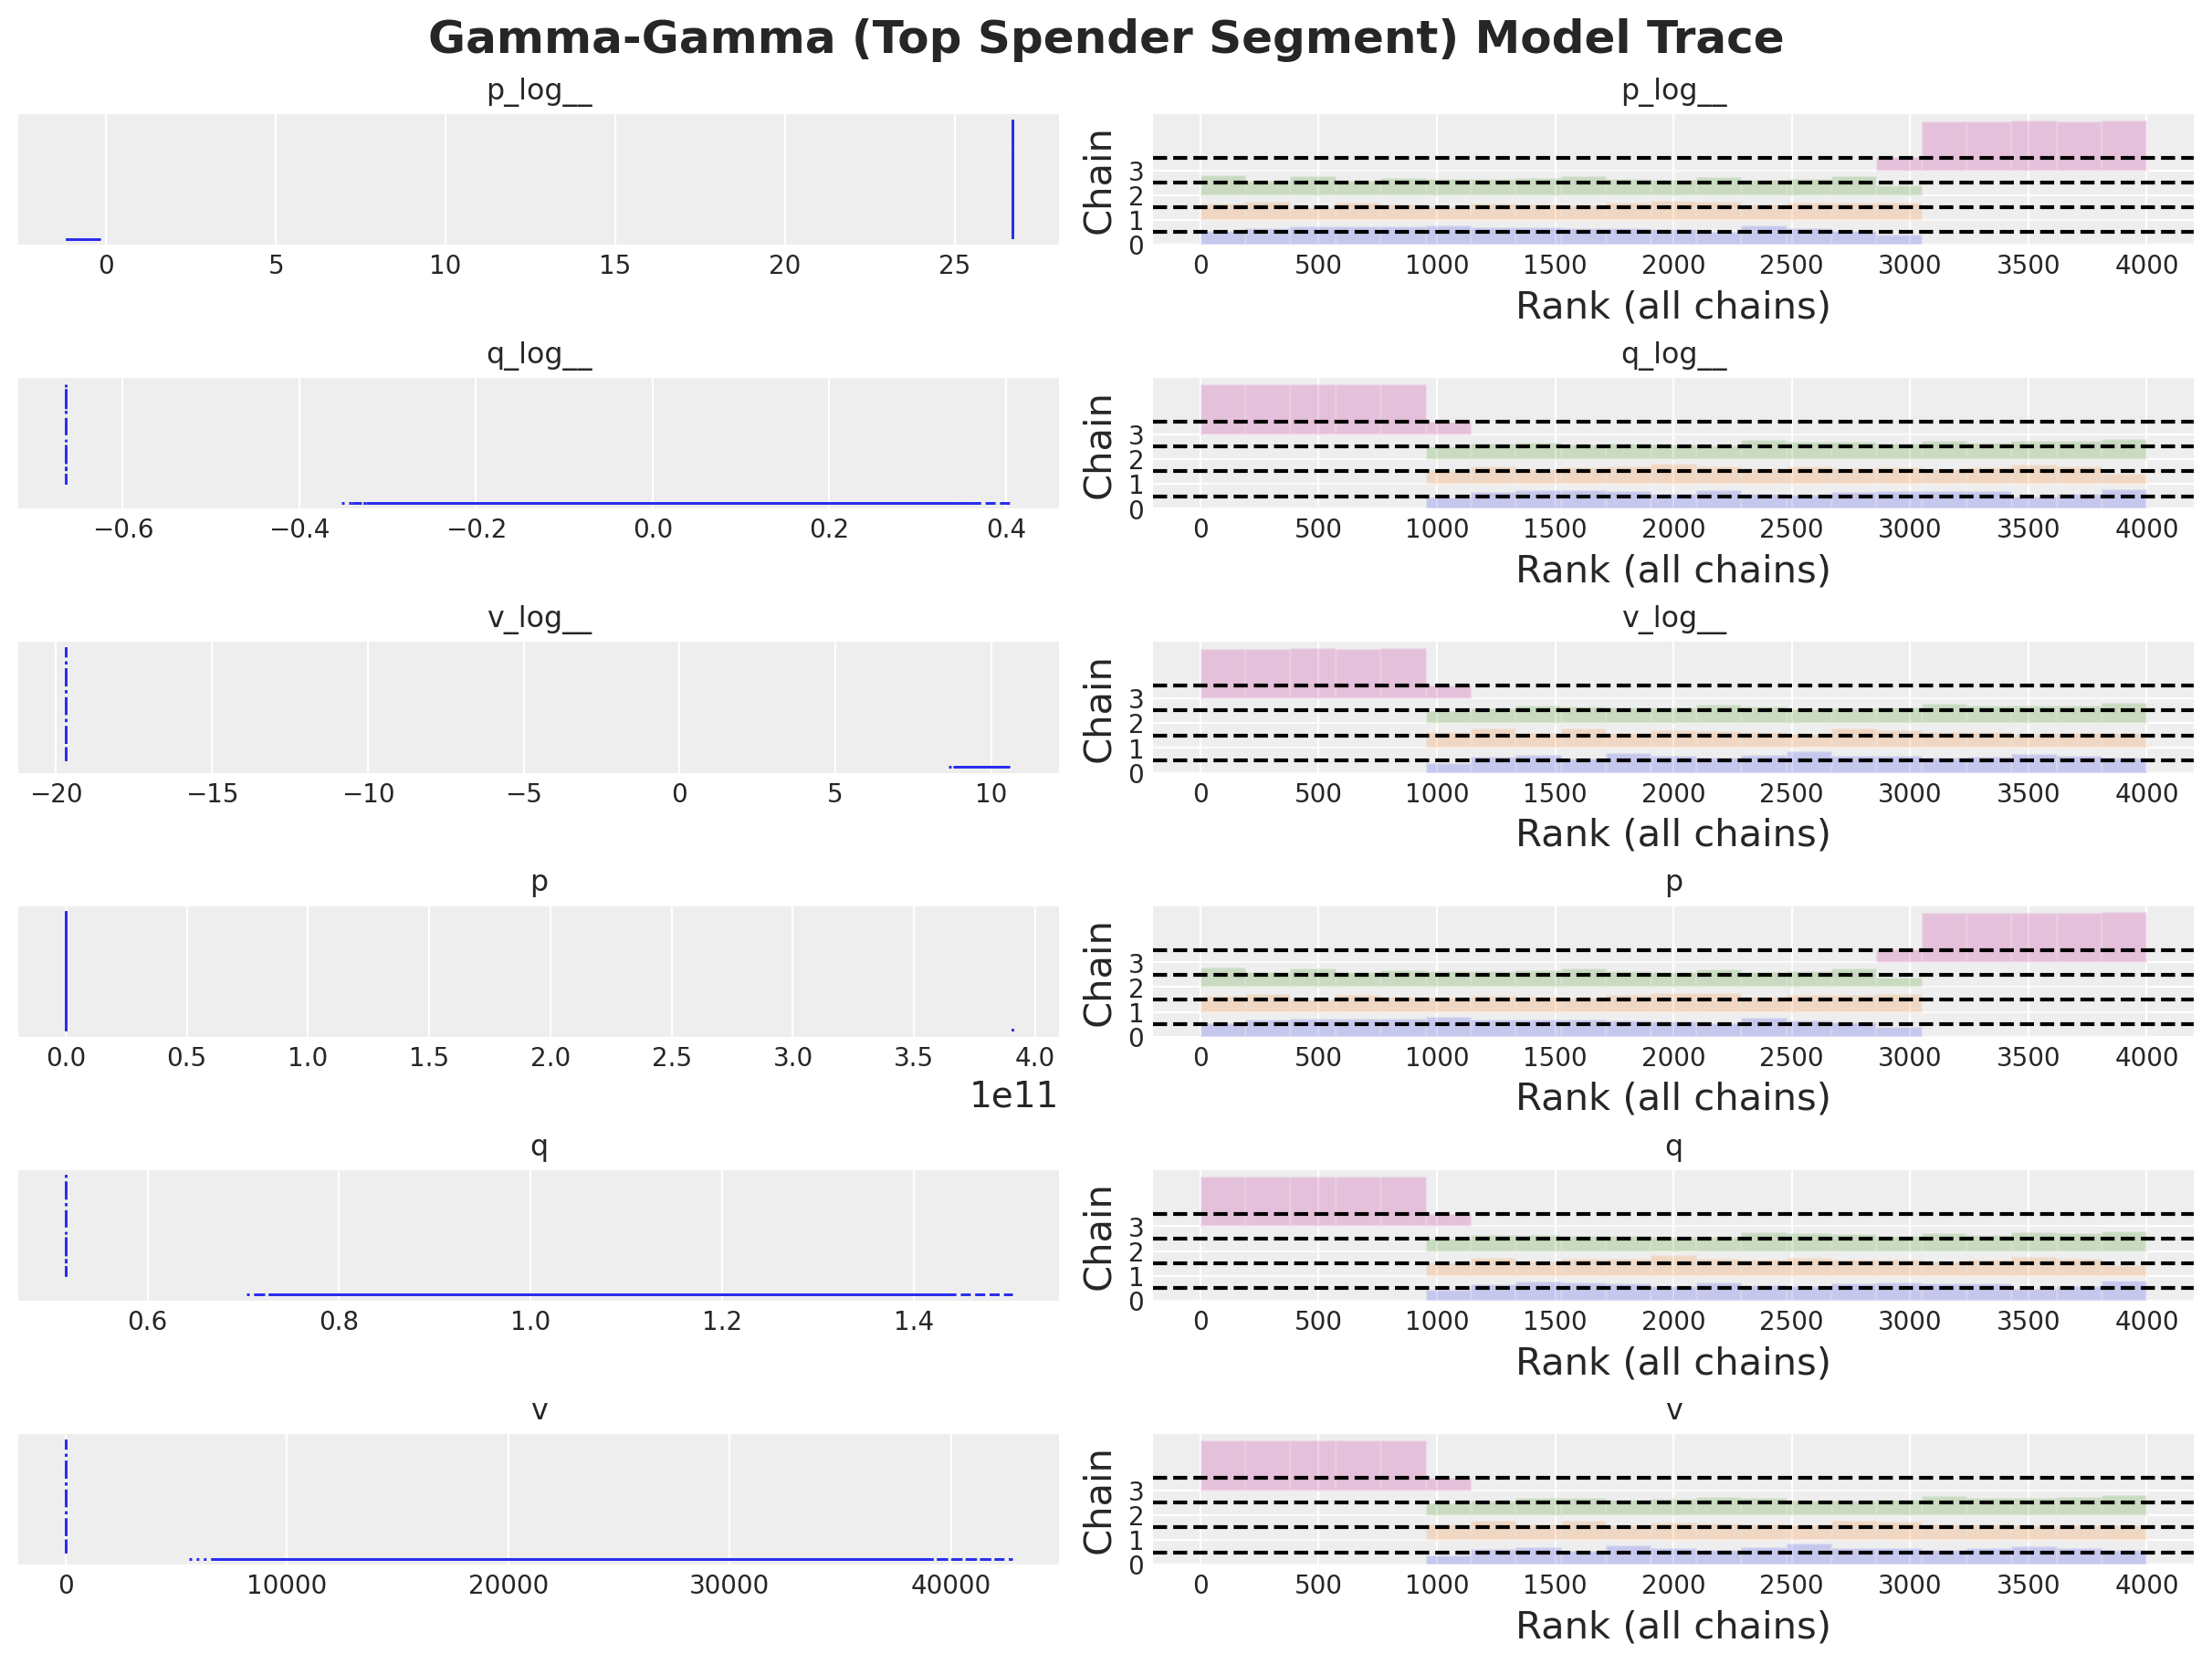

In [60]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma (Top Spender Segment) Model Trace", fontsize=18, fontweight="bold"
)
plt.show();

# Order Data Re-preprocessing for GammaGammaIndividual Model Fitting

In [59]:
order_data_indiv = order_data[
    ["INST_KEY", "ORDER_DATE", "M_NET_SALES", "INST_SCRAPPED_DATE"]
].copy()

order_data_indiv = order_data_indiv[
    (order_data_indiv["M_NET_SALES"] > 50)
    & (order_data_indiv["M_NET_SALES"] < 4000000)
    & (order_data_indiv["INST_SCRAPPED_DATE"].isna())
].copy()

In [60]:
order_data_indiv

INST_KEY  ORDER_DATE  M_NET_SALES  INST_SCRAPPED_DATE
0          48.00  2004-02-10    13,911.36                 NaN
6          63.00  2004-02-12     3,994.43                 NaN
7         435.00  2004-02-02       938.11                 NaN
10         41.00  2004-02-09     2,488.16                 NaN
12        155.00  2004-02-11     1,810.03                 NaN
...          ...         ...          ...                 ...
199641  3,400.00  2024-01-29    13,893.57                 NaN
199642    464.00  2024-01-11     5,633.87                 NaN
199644  2,548.00  2024-01-30        86.30                 NaN
199647  3,927.00  2023-12-15    18,755.00                 NaN
199660  3,967.00  2024-01-11    30,624.90                 NaN

[46619 rows x 4 columns]

In [61]:
segments_ids = rfm_df_model[["customer_id", "segment"]]

In [62]:
joined_indiv = pd.merge(
    left=order_data_indiv,
    right=segments_ids,
    left_on="INST_KEY",
    right_on="customer_id",
    how="inner",
)

In [63]:
joined_indiv

INST_KEY  ORDER_DATE  M_NET_SALES  INST_SCRAPPED_DATE  customer_id  \
0         48.00  2004-02-10    13,911.36                 NaN           48   
1         63.00  2004-02-12     3,994.43                 NaN           63   
2        435.00  2004-02-02       938.11                 NaN          435   
3         41.00  2004-02-09     2,488.16                 NaN           41   
4        155.00  2004-02-11     1,810.03                 NaN          155   
...         ...         ...          ...                 ...          ...   
30223  1,678.00  2024-01-19     7,159.25                 NaN         1678   
30224  1,284.00  2024-01-01       195.42                 NaN         1284   
30225     22.00  2024-01-12     1,197.50                 NaN           22   
30226    464.00  2024-01-11     5,633.87                 NaN          464   
30227  2,548.00  2024-01-30        86.30                 NaN         2548   

                segment  
0           Top Spender  
1           Low Spender  
2      At Risk Customer  
3      At Risk Customer  
4       Repeat Customer  
...                 ...  
30223  Premium Customer  
30224  Premium Customer  
30225  Premium Customer  
30226  At Risk Customer  
30227       Low Spender  

[30228 rows x 6 columns]

In [64]:
indiv_model_df = joined_indiv[["INST_KEY", "M_NET_SALES"]].copy()

indiv_model_df.rename(
    columns={
        "INST_KEY": "customer_id",
        "M_NET_SALES": "individual_transaction_value",
    },
    inplace=True,
)

In [65]:
indiv_model_df

customer_id  individual_transaction_value
0            48.00                     13,911.36
1            63.00                      3,994.43
2           435.00                        938.11
3            41.00                      2,488.16
4           155.00                      1,810.03
...            ...                           ...
30223     1,678.00                      7,159.25
30224     1,284.00                        195.42
30225        22.00                      1,197.50
30226       464.00                      5,633.87
30227     2,548.00                         86.30

[30228 rows x 2 columns]

## At-Risk GammaGammaIndividual

In [72]:
at_risk_ind = indiv_model_df[indiv_model_df["customer_id"].isin(at_risk["customer_id"])]

In [73]:
at_risk_ind.reset_index(drop=True, inplace=True)
at_risk_ind["customer_id"] = at_risk_ind["customer_id"].astype(int)
at_risk_ind.index = at_risk_ind["customer_id"]

C:\Users\adria\AppData\Local\Temp\ipykernel_182504\2116515121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_risk_ind["customer_id"] = at_risk_ind["customer_id"].astype(int)


In [74]:
at_risk_ind

customer_id  individual_transaction_value
customer_id                                           
435                  435                        938.11
41                    41                      2,488.16
87                    87                        284.62
58                    58                      3,150.58
435                  435                      2,354.66
...                  ...                           ...
1009                1009                      3,443.00
119                  119                      1,496.00
860                  860                      4,850.79
860                  860                        564.02
464                  464                      5,633.87

[1555 rows x 2 columns]

In [69]:
at_risk_ind = at_risk_ind.drop(columns="customer_id")

In [70]:
at_risk_ind

individual_transaction_value
customer_id                              
435                                938.11
41                               2,488.16
87                                 284.62
58                               3,150.58
435                              2,354.66
...                                   ...
1009                             3,443.00
119                              1,496.00
860                              4,850.79
860                                564.02
464                              5,633.87

[1555 rows x 1 columns]

In [71]:
model = clv.GammaGammaModelIndividual(data=at_risk_ind)

ValueError: Required column customer_id missing

In [ ]:
model.fit(method="mcmc", sampler_kwargs=sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
C:\Users\adria\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


In [ ]:
# indiv_model.fit()